## EDF to CSV

In [6]:
import pyedflib
import numpy as np
import pandas as pd
import commands

In [7]:
files = commands.getoutput('ls gait_pks_avc_ctrl/')
files = files.split('\n')

for i in files:
    
    file_name = pyedflib.EdfReader('gait_pks_avc_ctrl/'+i)
    n = file_name.signals_in_file
    signal_labels = file_name.getSignalLabels()
    sigbufs = np.zeros((n, file_name.getNSamples()[0]))
    for j in np.arange(n):
         sigbufs[j, :] = file_name.readSignal(j)
    
    file_name._close()
    
    df = pd.DataFrame(np.transpose(sigbufs))
    df.insert(loc=0, column='Time', value=np.arange(0,len(df)*0.0005,0.0005))

    df = df.rename(columns={0: 'Channel 1'})
    df = df.rename(columns={1: 'Channel 2'})
    df = df.rename(columns={2: 'Channel 3'})
    df = df.rename(columns={3: 'Channel 4'})

    df.to_csv('gait_pks_avc_ctrl/'+i[:-3]+'csv', sep='\t', encoding='utf-8')

IOError: the file is not EDF(+) or BDF(+) compliant (it contains format errors)

---
## Filtro Passa-Altas e Passa-Banda

In [8]:
def filter_signal(emg, low_pass=10., sfreq=2000., high_band=20., low_band=450.):
    """
    emg: EMG data
    high: high-pass cut off frequency
    low: low-pass cut off frequency
    sfreq: sampling frequency
    """
    
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(sfreq/2)
    low_band = low_band/(sfreq/2)
    
    # create bandpass filter for EMG
    b1, a1 = sp.signal.butter(4, [high_band,low_band], btype='bandpass')
    
    # process EMG signal: filter EMG
    emg_filtered = sp.signal.filtfilt(b1, a1, emg)    
    
    # process EMG signal: rectify
    emg_rectified = emg_filtered
    #emg_rectified = abs(emg_filtered)
    
    # create lowpass filter and apply to rectified signal to get EMG envelope
    low_pass = low_pass/sfreq
    b2, a2 = sp.signal.butter(4, low_pass, btype='lowpass')
    emg_envelope = sp.signal.filtfilt(b2, a2, emg_rectified)
    
    return emg_envelope

In [9]:
def plot_fremgp(df):    
    
    fig = plt.figure()
    ax1 = plt.subplot(4, 1, 1).xaxis.set_visible(False)
    plt.plot(df['VL'][3000:], linewidth=0.6)
    plt.xlabel('Samples')
    plt.ylabel('mV').set_rotation(0)
    plt.title('Channel 1')

    ax1 = plt.subplot(4, 1, 2).xaxis.set_visible(False)
    plt.plot(df['GM'][3000:], linewidth=0.6)
    plt.xlabel('Samples')
    plt.ylabel('mV').set_rotation(0)
    plt.title('Channel 2')

    ax1 = plt.subplot(4, 1, 3).xaxis.set_visible(False)
    plt.plot(df['SM'][3000:], linewidth=0.6)
    plt.xlabel('Samples')
    plt.ylabel('mV').set_rotation(0)
    plt.title('Channel 3')

    ax1 = plt.subplot(4, 1, 4).xaxis.set_visible(False)
    plt.plot(df['BF'][3000:], linewidth=0.6)
    plt.xlabel('Samples')
    plt.ylabel('mV').set_rotation(0)
    plt.title('Channel 4')

    

    #fig_name = FILE_+'_filtered'+str(180)+'.png'
    fig.set_size_inches(w=10,h=12)
    #fig.savefig('./graphs/'+fig_name)

In [42]:
#Xc = filter_signal(df['VL'], low_pass=180)
df['VL'] = filter_signal(df['VL'], low_pass=10)
df['GM'] = filter_signal(df['GM'], low_pass=10)
df['SM'] = filter_signal(df['SM'], low_pass=10)
df['BF'] = filter_signal(df['BF'], low_pass=10)

#plot_fremgp(df)


In [155]:
def plot_emg(FILE_,Xc):    
    
    fig = plt.figure()
    ax1 = plt.subplot(4, 1, 1).xaxis.set_visible(False)
    plt.plot(Xc[:, 0], linewidth=0.2)
    plt.xlabel('Samples')
    plt.ylabel('mV').set_rotation(0)
    plt.title(FILE_+'\nVL-d')

    # pass sharey=ax1 to ensure the two subplots share the same y axis
    ax2 = plt.subplot(4, 1, 2, sharey=ax1).xaxis.set_visible(False)
    plt.plot(Xc[:, 1], linewidth=0.2)
    plt.xlabel('Samples')
    plt.ylabel('mV').set_rotation(0)
    plt.title('GM-e')

    ax3 = plt.subplot(4, 1, 3, sharey=ax1).xaxis.set_visible(False)
    plt.plot(Xc[:, 2], linewidth=0.2)
    plt.xlabel('Samples')
    plt.ylabel('mV').set_rotation(0)
    plt.title('SM-e')
    
    ax4 = plt.subplot(4, 1, 4, sharey=ax1)
    plt.plot(Xc[:, 3], linewidth=0.2)
    plt.xlabel('Samples')
    plt.ylabel('mV').set_rotation(0)
    plt.title('BF-d')
    
    fig_name = FILE_+'.png'
    fig.set_size_inches(w=12,h=8)
    fig.savefig('./graphs/'+fig_name)

In [41]:
def plot_fremg(df):   
    # plot graphs
    fig = plt.figure()
    

    #plt.subplot(4, 1, 1).xaxis.set_visible(False)
    plt.subplot(4, 1, 1).set_title('Filtered, rectified ' + '\n' + 'EMG envelope: ' + str(int(10)) + ' Hz' + '\n VL-d')
    plt.plot(df['Time'][2000:], df['VL'][2000:], linewidth=0.6)
    plt.locator_params(axis='x', nbins=4)
    plt.locator_params(axis='y', nbins=4)
    plt.axvspan(1.27, 3.0, facecolor='#F08080', alpha=0.5)
    plt.axvspan(2.99, 4.73, facecolor='#70659e', alpha=0.5)
    plt.axvspan(4.72, 6.45, facecolor='#F08080', alpha=0.5)
    plt.axvspan(6.44, 8.18, facecolor='#70659e', alpha=0.5)
    plt.axvspan(8.17, 9.91, facecolor='#F08080', alpha=0.5)
    plt.axvspan(9.90, 11.64, facecolor='#70659e', alpha=0.5)

    plt.annotate('C1', xy=((1.73+0.3), df['VL'][2000:].max()*.85))  
    plt.annotate('C2', xy=((2*1.73+0.3), df['VL'][2000:].max()*.85))
    plt.annotate('C3', xy=((3*1.73+0.3), df['VL'][2000:].max()*.85))
    plt.annotate('C4', xy=((4*1.73+0.3), df['VL'][2000:].max()*.85))
    plt.annotate('C5', xy=((5*1.73+0.3), df['VL'][2000:].max()*.85))
    plt.annotate('C6', xy=((6*1.73+0.3), df['VL'][2000:].max()*.85))
    #plt.annotate('C7', xy=((7*1.73+0.3), df['VL'][2000:].max()*.85))
    plt.ylabel('EMG (m.v.)')
    #plt.xlabel('Time (sec)')
    
 
    plt.subplot(4, 1, 2).set_title('GM-e')
    plt.plot(df['Time'][2000:], df['GM'][2000:], linewidth=0.6)
    plt.locator_params(axis='x', nbins=4)
    plt.locator_params(axis='y', nbins=4)
    plt.axvspan(1.27, 3.0, facecolor='#F08080', alpha=0.5)
    plt.axvspan(2.99, 4.73, facecolor='#70659e', alpha=0.5)
    plt.axvspan(4.72, 6.45, facecolor='#F08080', alpha=0.5)
    plt.axvspan(6.44, 8.18, facecolor='#70659e', alpha=0.5)
    plt.axvspan(8.17, 9.91, facecolor='#F08080', alpha=0.5)
    plt.axvspan(9.90, 11.64, facecolor='#70659e', alpha=0.5)

    plt.annotate('C1', xy=((1.73+0.3), df['GM'][2000:].max()*.85))  
    plt.annotate('C2', xy=((2*1.73+0.3), df['GM'][2000:].max()*.85))
    plt.annotate('C3', xy=((3*1.73+0.3), df['GM'][2000:].max()*.85))
    plt.annotate('C4', xy=((4*1.73+0.3), df['GM'][2000:].max()*.85))
    plt.annotate('C5', xy=((5*1.73+0.3), df['GM'][2000:].max()*.85))
    plt.annotate('C6', xy=((6*1.73+0.3), df['GM'][2000:].max()*.85))
    #plt.annotate('C7', xy=((7*1.73+0.3), df['GM'][2000:].max()*.85))
    plt.ylabel('EMG (m.v.)')
    #plt.xlabel('Time (sec)')
    
    
    plt.subplot(4, 1, 3).set_title('SM-e')
    plt.plot(df['Time'][2000:], df['SM'][2000:], linewidth=0.6)
    plt.locator_params(axis='x', nbins=4)
    plt.locator_params(axis='y', nbins=4)
    plt.axvspan(1.27, 3.0, facecolor='#F08080', alpha=0.5)
    plt.axvspan(2.99, 4.73, facecolor='#70659e', alpha=0.5)
    plt.axvspan(4.72, 6.45, facecolor='#F08080', alpha=0.5)
    plt.axvspan(6.44, 8.18, facecolor='#70659e', alpha=0.5)
    plt.axvspan(8.17, 9.91, facecolor='#F08080', alpha=0.5)
    plt.axvspan(9.90, 11.64, facecolor='#70659e', alpha=0.5)

    plt.annotate('C1', xy=((1.73+0.3), df['SM'][2000:].max()*.85))  
    plt.annotate('C2', xy=((2*1.73+0.3), df['SM'][2000:].max()*.85))
    plt.annotate('C3', xy=((3*1.73+0.3), df['SM'][2000:].max()*.85))
    plt.annotate('C4', xy=((4*1.73+0.3), df['SM'][2000:].max()*.85))
    plt.annotate('C5', xy=((5*1.73+0.3), df['SM'][2000:].max()*.85))
    plt.annotate('C6', xy=((6*1.73+0.3), df['SM'][2000:].max()*.85))
    #plt.annotate('C7', xy=((7*1.73+0.3), df['SM'][2000:].max()*.85))
    plt.ylabel('EMG (m.v.)')
    #plt.xlabel('Time (sec)')
    
    
    plt.subplot(4, 1, 4).set_title('BF-d')
    plt.plot(df['Time'][2000:], df['BF'][2000:], linewidth=0.6)
    plt.locator_params(axis='x', nbins=4)
    plt.locator_params(axis='y', nbins=4)
    plt.axvspan(1.27, 3.0, facecolor='#F08080', alpha=0.5)
    plt.axvspan(2.99, 4.73, facecolor='#70659e', alpha=0.5)
    plt.axvspan(4.72, 6.45, facecolor='#F08080', alpha=0.5)
    plt.axvspan(6.44, 8.18, facecolor='#70659e', alpha=0.5)
    plt.axvspan(8.17, 9.91, facecolor='#F08080', alpha=0.5)
    plt.axvspan(9.90, 11.64, facecolor='#70659e', alpha=0.5)

    plt.annotate('C1', xy=((1.73+0.3), df['BF'][2000:].max()*.85))  
    plt.annotate('C2', xy=((2*1.73+0.3), df['BF'][2000:].max()*.85))
    plt.annotate('C3', xy=((3*1.73+0.3), df['BF'][2000:].max()*.85))
    plt.annotate('C4', xy=((4*1.73+0.3), df['BF'][2000:].max()*.85))
    plt.annotate('C5', xy=((5*1.73+0.3), df['BF'][2000:].max()*.85))
    plt.annotate('C6', xy=((6*1.73+0.3), df['BF'][2000:].max()*.85))
    #plt.annotate('C7', xy=((7*1.73+0.3), df['BF'][2000:].max()*.85))
    plt.ylabel('EMG (m.v.)')
    plt.xlabel('Time (sec)')
    
    fig.set_size_inches(w=10,h=18)
    
#plot_fremg(df)

## Root  Mean  Square - RMS

$\hat{x} = \sqrt{\frac{1}{N}\sum_{k=1}^{N}\left[ x(k) \right]^2} \mapsto k=1,2,\dots , N$

O  valor  RMS  permite  caracterizar  o  sinal  de acordo  com  a estimativa  da  quantidade  de  energia,  relacionada  com  sua  amplitude,  em certo  intervalo  de  tempo.  Para  um  sinal  discreto  que  consiste  em N amostras  igualmente espaçadas, $x(k)$. 

In [38]:
def rms(a, window_size):
    def subrms(a, window_size):
        a2 = np.power(a,2)
        window = np.ones(window_size)/float(window_size)
        return np.sqrt(np.convolve(a2, window, 'valid'))

    for i in range(a.shape[1]):
        if i == 0:
            Xc = subrms(a[:, i], window_size)
        else:
            Xcp = subrms(a[:, i], window_size)
            Xc = np.vstack((Xc,Xcp))
    return np.transpose(Xc)

## Mean Absolute Value - MAV

$\bar{x} = \frac{1}{N}\sum_{k=1}^{N-1} |x(k)|$

É  uma  estimativa  do valor  médio  absoluto  do  sinal $x(k)$ com N amostras  de  comprimento.

In [39]:
def mav(a, window_size):
    def submav(a, window_size):
        a = np.abs(a)
        window = np.ones(window_size)/float(window_size)
        return np.convolve(a, window, 'valid')


    for i in range(a.shape[1]):
        if i == 0:
            Xc = submav(a[:, i], window_size)
        else:
            Xcp = submav(a[:, i], window_size)
            Xc = np.vstack((Xc,Xcp))
    return np.transpose(Xc)

## Sampling Variance - VAR

$\sigma^{2}_{i} = \frac{1}{N-1}\sum_{k=0}^{N-1} ( x(k) - \bar{x} (i)  ) ^{2}$

$\bar{x}(i) = \frac{1}{N}\sum_{k=0}^{N-1} x(i-k)$

O parâmetro é utilizado para estimar a densidade de potência  do  sinal  mioelétrico  no  segmento $i$ para $N$ número  de  amostras.

In [40]:
def f_var(a, window_size):
    def subf(a, window_size):
        Z = np.array([])
        for i in range(len(a)-window_size):
            Z = np.append(Z,np.var(a[i:window_size+i]))
        return Z
            
    for i in range(a.shape[1]):
        if i == 0:
            Xc = subf(a[:, i], window_size)
        else:
            Xcp = subf(a[:, i], window_size)
            Xc = np.vstack((Xc,Xcp))
    return np.transpose(Xc)


# Controle

In [21]:
import os
import pandas as pd
import numpy as np
import scipy as sp
from scipy import signal
#from ml_time_series import generate_envelope
import ml_time_series as mls
import timeit
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib notebook

In [76]:
import os
import pandas as pd

DATADIR = "gait_pks_avc_ctrl"
DATAFILE = "Alexandre Moreira  - Dia 17.08.25 as 17.25.26.csv"

datafile = os.path.join(DATADIR, DATAFILE)
df1 = pd.read_csv(datafile, sep="\t", skiprows=1, header=None, names=['Time', 'VL', 'GM', 'SM', 
                                                                    'BF'])
df1.head()

Time         VL        GM         SM         BF
0  0.0000 -17.538515  6.240741 -16.333333 -11.472656
1  0.0005 -11.915546  6.240741  -3.647619  -2.983594
2  0.0010 -10.509804 -0.907407 -16.333333  -5.813281
3  0.0015   0.736134  4.811111 -17.742857  -4.398438
4  0.0020   3.547619  6.240741 -14.923810 -15.717187

<IPython.core.display.Javascript object>


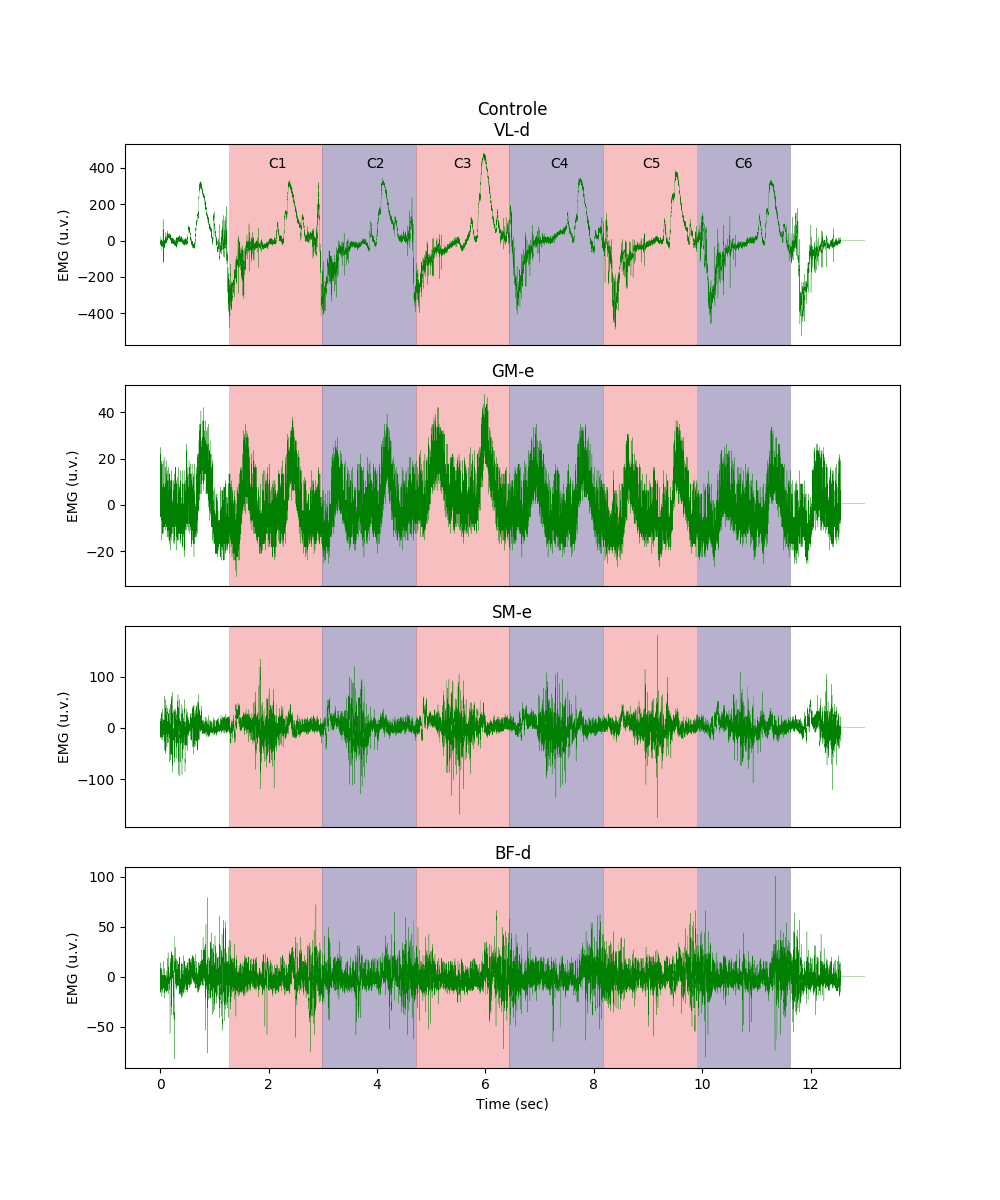

In [183]:
###### %matplotlib notebook
import matplotlib.pyplot as plt



fig1 = plt.figure()
ax1 = plt.subplot(4, 1, 1).xaxis.set_visible(False)
plt.plot(df1['Time'],df1['VL'], linewidth=0.2, color = '#008000')
plt.xlabel('Sample')
plt.ylabel('EMG (u.v.)')
plt.title('Controle'+'\nVL-d')

plt.axvspan(1.27, 3.0, facecolor='#F08080', alpha=0.5)
plt.axvspan(2.99, 4.73, facecolor='#70659e', alpha=0.5)
plt.axvspan(4.72, 6.45, facecolor='#F08080', alpha=0.5)
plt.axvspan(6.44, 8.18, facecolor='#70659e', alpha=0.5)
plt.axvspan(8.17, 9.91, facecolor='#F08080', alpha=0.5)
plt.axvspan(9.90, 11.64, facecolor='#70659e', alpha=0.5)

plt.annotate('C1', xy=(2.0, 400))
plt.annotate('C2', xy=(3.8, 400))
plt.annotate('C3', xy=(5.4, 400))
plt.annotate('C4', xy=(7.2, 400))
plt.annotate('C5', xy=(8.9, 400))
plt.annotate('C6', xy=(10.6, 400))

ax2 = plt.subplot(4, 1, 2).xaxis.set_visible(False)
plt.plot(df1['Time'],df1['GM'], linewidth=0.2, color = '#008000')
#plt.xlabel('Sample')
#plt.ylabel('mV')
plt.title('GM-e')
plt.ylabel('EMG (u.v.)')

plt.axvspan(1.27, 3.0, facecolor='#F08080', alpha=0.5)
plt.axvspan(2.99, 4.73, facecolor='#70659e', alpha=0.5)
plt.axvspan(4.72, 6.45, facecolor='#F08080', alpha=0.5)
plt.axvspan(6.44, 8.18, facecolor='#70659e', alpha=0.5)
plt.axvspan(8.17, 9.91, facecolor='#F08080', alpha=0.5)
plt.axvspan(9.90, 11.64, facecolor='#70659e', alpha=0.5)

ax3 = plt.subplot(4, 1, 3).xaxis.set_visible(False)
plt.plot(df1['Time'],df1['SM'], linewidth=0.2, color = '#008000')
#plt.xlabel('Sample')
#plt.ylabel('mV')
plt.title('SM-e')
plt.ylabel('EMG (u.v.)')

plt.axvspan(1.27, 3.0, facecolor='#F08080', alpha=0.5)
plt.axvspan(2.99, 4.73, facecolor='#70659e', alpha=0.5)
plt.axvspan(4.72, 6.45, facecolor='#F08080', alpha=0.5)
plt.axvspan(6.44, 8.18, facecolor='#70659e', alpha=0.5)
plt.axvspan(8.17, 9.91, facecolor='#F08080', alpha=0.5)
plt.axvspan(9.90, 11.64, facecolor='#70659e', alpha=0.5)
            
ax4 = plt.subplot(4, 1, 4)
plt.plot(df1['Time'],df1['BF'], linewidth=0.2, color = '#008000')
plt.xlabel('Time (sec)')
plt.title('BF-d')
plt.ylabel('EMG (u.v.)')

plt.axvspan(1.27, 3.0, facecolor='#F08080', alpha=0.5)
plt.axvspan(2.99, 4.73, facecolor='#70659e', alpha=0.5)
plt.axvspan(4.72, 6.45, facecolor='#F08080', alpha=0.5)
plt.axvspan(6.44, 8.18, facecolor='#70659e', alpha=0.5)
plt.axvspan(8.17, 9.91, facecolor='#F08080', alpha=0.5)
plt.axvspan(9.90, 11.64, facecolor='#70659e', alpha=0.5)

fig1.set_size_inches(w=10,h=12)
fig1.savefig('./graphs/controle.png')

In [72]:
df1_f = df1
df1_f['VL'] = filter_signal(df1['VL'], low_pass=10)
df1_f['GM'] = filter_signal(df1['GM'], low_pass=10)
df1_f['SM'] = filter_signal(df1['SM'], low_pass=10)
df1_f['BF'] = filter_signal(df1['BF'], low_pass=10)
df1_f.head()

Time        VL        GM        SM        BF
0  0.0000 -2.611495  0.677498 -2.746880 -1.477583
1  0.0005 -2.581234  0.668588 -2.714515 -1.459941
2  0.0010 -2.551011  0.659701 -2.682192 -1.442324
3  0.0015 -2.520827  0.650836 -2.649913 -1.424734
4  0.0020 -2.490687  0.641995 -2.617683 -1.407173

<IPython.core.display.Javascript object>


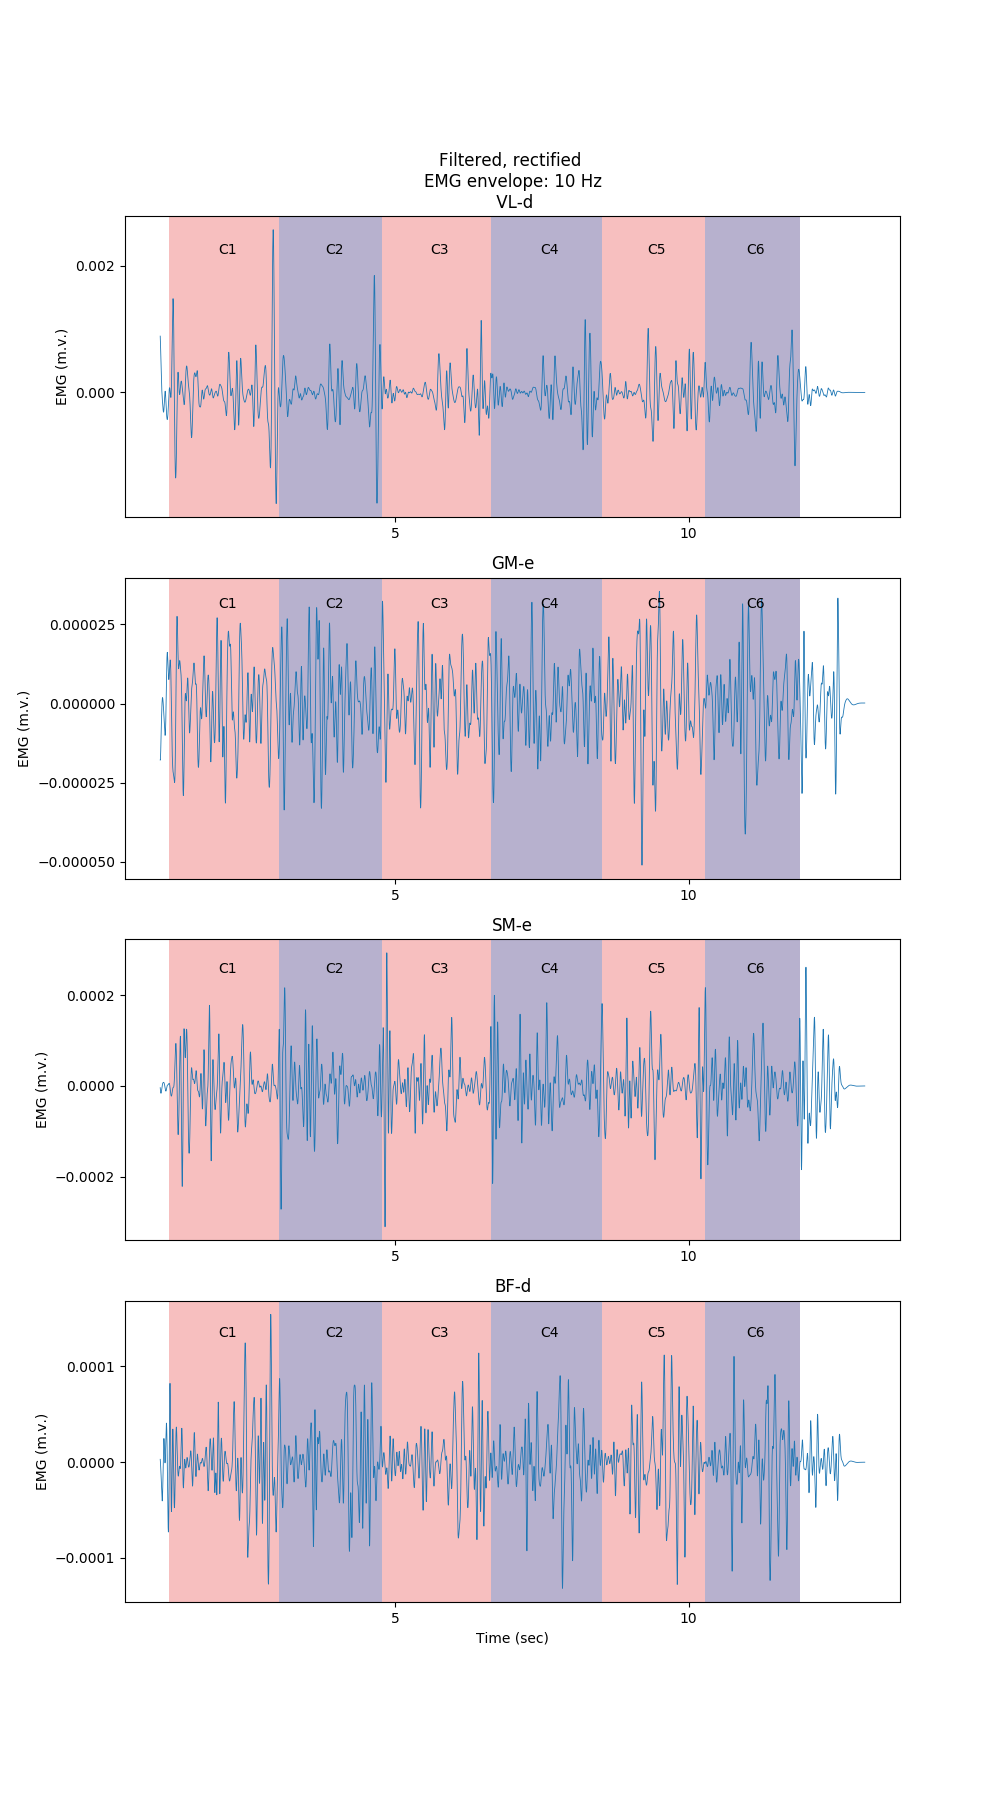

In [73]:
fig = plt.figure()
#plt.subplot(4, 1, 1).xaxis.set_visible(False)
plt.subplot(4, 1, 1).set_title('Filtered, rectified ' + '\n' + 'EMG envelope: ' + str(int(10)) + ' Hz' + '\n VL-d')
plt.plot(df1_f['Time'][2000:], df1_f['VL'][2000:], linewidth=0.6)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.axvspan(1.15, 3.03, facecolor='#F08080', alpha=0.5)
plt.axvspan(3.03, 4.78, facecolor='#70659e', alpha=0.5)
plt.axvspan(4.78, 6.63, facecolor='#F08080', alpha=0.5)
plt.axvspan(6.63, 8.52, facecolor='#70659e', alpha=0.5)
plt.axvspan(8.52, 10.28, facecolor='#F08080', alpha=0.5)
plt.axvspan(10.28, 11.89, facecolor='#70659e', alpha=0.5)

plt.annotate('C1', xy=(((1.15+3.03)/2-0.1), df1_f['VL'][2000:].max()*.85))  
plt.annotate('C2', xy=(((3.03+4.78)/2-0.1), df1_f['VL'][2000:].max()*.85))
plt.annotate('C3', xy=(((4.78+6.63)/2-0.1), df1_f['VL'][2000:].max()*.85))
plt.annotate('C4', xy=(((6.63+8.52)/2-0.1), df1_f['VL'][2000:].max()*.85))
plt.annotate('C5', xy=(((8.52+10.28)/2-0.1), df1_f['VL'][2000:].max()*.85))
plt.annotate('C6', xy=(((10.28+11.89)/2-0.1), df1_f['VL'][2000:].max()*.85))
#plt.annotate('C7', xy=((7*1.73+0.3), df['VL'][2000:].max()*.85))
plt.ylabel('EMG (m.v.)')
#plt.xlabel('Time (sec)')


plt.subplot(4, 1, 2).set_title('GM-e')
plt.plot(df1_f['Time'][2000:], df1_f['GM'][2000:], linewidth=0.6)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.axvspan(1.15, 3.03, facecolor='#F08080', alpha=0.5)
plt.axvspan(3.03, 4.78, facecolor='#70659e', alpha=0.5)
plt.axvspan(4.78, 6.63, facecolor='#F08080', alpha=0.5)
plt.axvspan(6.63, 8.52, facecolor='#70659e', alpha=0.5)
plt.axvspan(8.52, 10.28, facecolor='#F08080', alpha=0.5)
plt.axvspan(10.28, 11.89, facecolor='#70659e', alpha=0.5)

plt.annotate('C1', xy=(((1.15+3.03)/2-0.1), df1_f['GM'][2000:].max()*.85))  
plt.annotate('C2', xy=(((3.03+4.78)/2-0.1), df1_f['GM'][2000:].max()*.85))
plt.annotate('C3', xy=(((4.78+6.63)/2-0.1), df1_f['GM'][2000:].max()*.85))
plt.annotate('C4', xy=(((6.63+8.52)/2-0.1), df1_f['GM'][2000:].max()*.85))
plt.annotate('C5', xy=(((8.52+10.28)/2-0.1), df1_f['GM'][2000:].max()*.85))
plt.annotate('C6', xy=(((10.28+11.89)/2-0.1), df1_f['GM'][2000:].max()*.85))
#plt.annotate('C7', xy=((7*1.73+0.3), df['GM'][2000:].max()*.85))
plt.ylabel('EMG (m.v.)')
#plt.xlabel('Time (sec)')


plt.subplot(4, 1, 3).set_title('SM-e')
plt.plot(df1_f['Time'][2000:], df1_f['SM'][2000:], linewidth=0.6)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.axvspan(1.15, 3.03, facecolor='#F08080', alpha=0.5)
plt.axvspan(3.03, 4.78, facecolor='#70659e', alpha=0.5)
plt.axvspan(4.78, 6.63, facecolor='#F08080', alpha=0.5)
plt.axvspan(6.63, 8.52, facecolor='#70659e', alpha=0.5)
plt.axvspan(8.52, 10.28, facecolor='#F08080', alpha=0.5)
plt.axvspan(10.28, 11.89, facecolor='#70659e', alpha=0.5)

plt.annotate('C1', xy=(((1.15+3.03)/2-0.1), df1_f['SM'][2000:].max()*.85))  
plt.annotate('C2', xy=(((3.03+4.78)/2-0.1), df1_f['SM'][2000:].max()*.85))
plt.annotate('C3', xy=(((4.78+6.63)/2-0.1), df1_f['SM'][2000:].max()*.85))
plt.annotate('C4', xy=(((6.63+8.52)/2-0.1), df1_f['SM'][2000:].max()*.85))
plt.annotate('C5', xy=(((8.52+10.28)/2-0.1), df1_f['SM'][2000:].max()*.85))
plt.annotate('C6', xy=(((10.28+11.89)/2-0.1), df1_f['SM'][2000:].max()*.85))
#plt.annotate('C7', xy=((7*1.73+0.3), df['SM'][2000:].max()*.85))
plt.ylabel('EMG (m.v.)')
#plt.xlabel('Time (sec)')


plt.subplot(4, 1, 4).set_title('BF-d')
plt.plot(df1_f['Time'][2000:], df1_f['BF'][2000:], linewidth=0.6)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.axvspan(1.15, 3.03, facecolor='#F08080', alpha=0.5)
plt.axvspan(3.03, 4.78, facecolor='#70659e', alpha=0.5)
plt.axvspan(4.78, 6.63, facecolor='#F08080', alpha=0.5)
plt.axvspan(6.63, 8.52, facecolor='#70659e', alpha=0.5)
plt.axvspan(8.52, 10.28, facecolor='#F08080', alpha=0.5)
plt.axvspan(10.28, 11.89, facecolor='#70659e', alpha=0.5)

plt.annotate('C1', xy=(((1.15+3.03)/2-0.1), df1_f['BF'][2000:].max()*.85))  
plt.annotate('C2', xy=(((3.03+4.78)/2-0.1), df1_f['BF'][2000:].max()*.85))
plt.annotate('C3', xy=(((4.78+6.63)/2-0.1), df1_f['BF'][2000:].max()*.85))
plt.annotate('C4', xy=(((6.63+8.52)/2-0.1), df1_f['BF'][2000:].max()*.85))
plt.annotate('C5', xy=(((8.52+10.28)/2-0.1), df1_f['BF'][2000:].max()*.85))
plt.annotate('C6', xy=(((10.28+11.89)/2-0.1), df1_f['BF'][2000:].max()*.85))
#plt.annotate('C7', xy=((7*1.73+0.3), df['BF'][2000:].max()*.85))
plt.ylabel('EMG (m.v.)')
plt.xlabel('Time (sec)')

fig.set_size_inches(w=10,h=18)
fig1.savefig('./gait_pks_avc_ctrl/controle_filtrado.png')

In [171]:
# Sinal cru
df1a = df1.as_matrix(columns=df1.columns[1:])

# Sinal filtrado
#df1a = df1_f.as_matrix(columns=df1_f.columns[1:])

In [206]:
rms1 = rms(df1a,50)
df1_r = pd.DataFrame(data=rms1, columns=['VL', 'GM', 'SM', 'BF'])
df1_r.to_csv('./dados_filtrados/RMS - Controle.csv', sep='\t', encoding='utf-8')
df1_r.head()

VL        GM         SM        BF
0  21.462990  7.842507  11.912354  7.048858
1  21.370939  7.793038  11.686546  6.967639
2  21.472195  7.757653  12.430891  7.003273
3  21.640524  8.049085  12.503572  7.029571
4  21.886766  8.400888  12.628603  7.107880

<IPython.core.display.Javascript object>


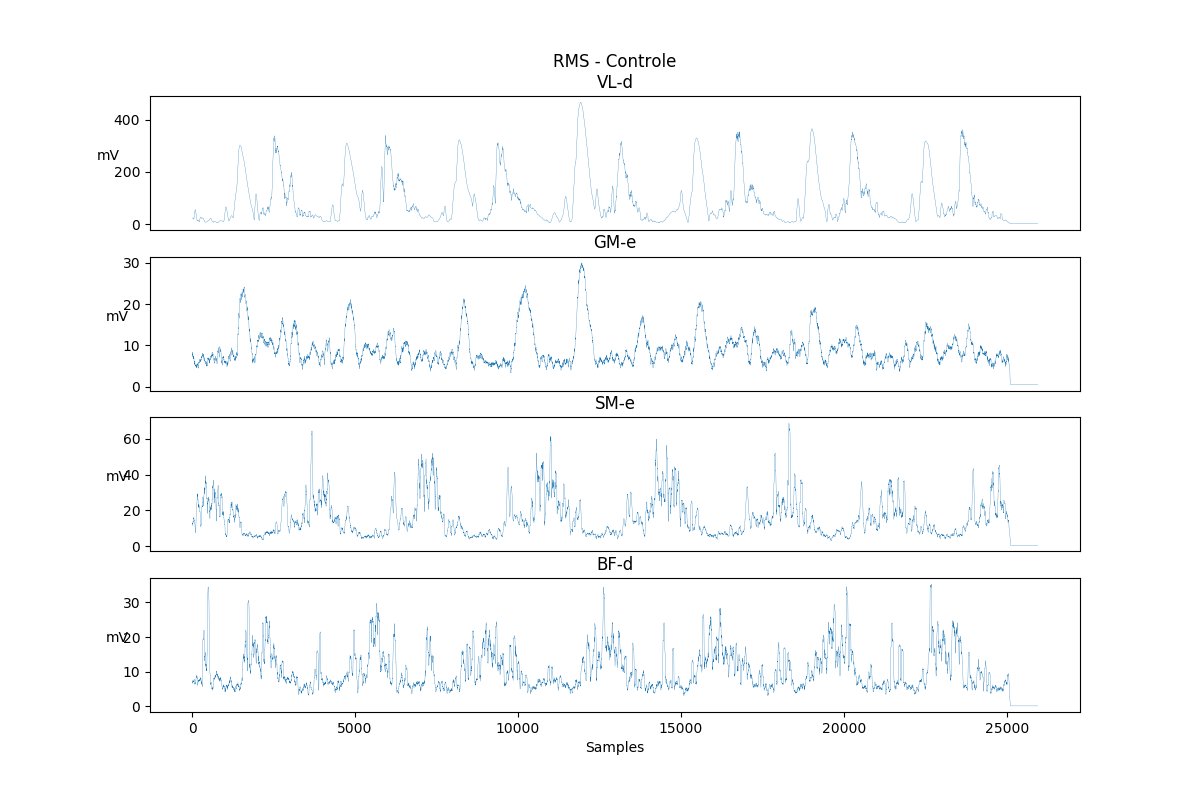

In [207]:
plot_emg("RMS - Controle",rms1)

In [208]:
mav1 = mav(df1a,50)
df1_m = pd.DataFrame(data=mav1, columns=['VL', 'GM', 'SM', 'BF'])
df1_m.to_csv('./dados_filtrados/MAV - Controle.csv', sep='\t', encoding='utf-8')
df1_m.head()

VL        GM        SM        BF
0  16.093840  6.073630  9.491810  5.992891
1  15.953266  5.959259  9.176762  5.936297
2  16.093840  5.902074  9.707429  5.992891
3  16.318759  6.188000  9.758857  6.021187
4  16.767266  6.445333  9.838476  6.106078

<IPython.core.display.Javascript object>


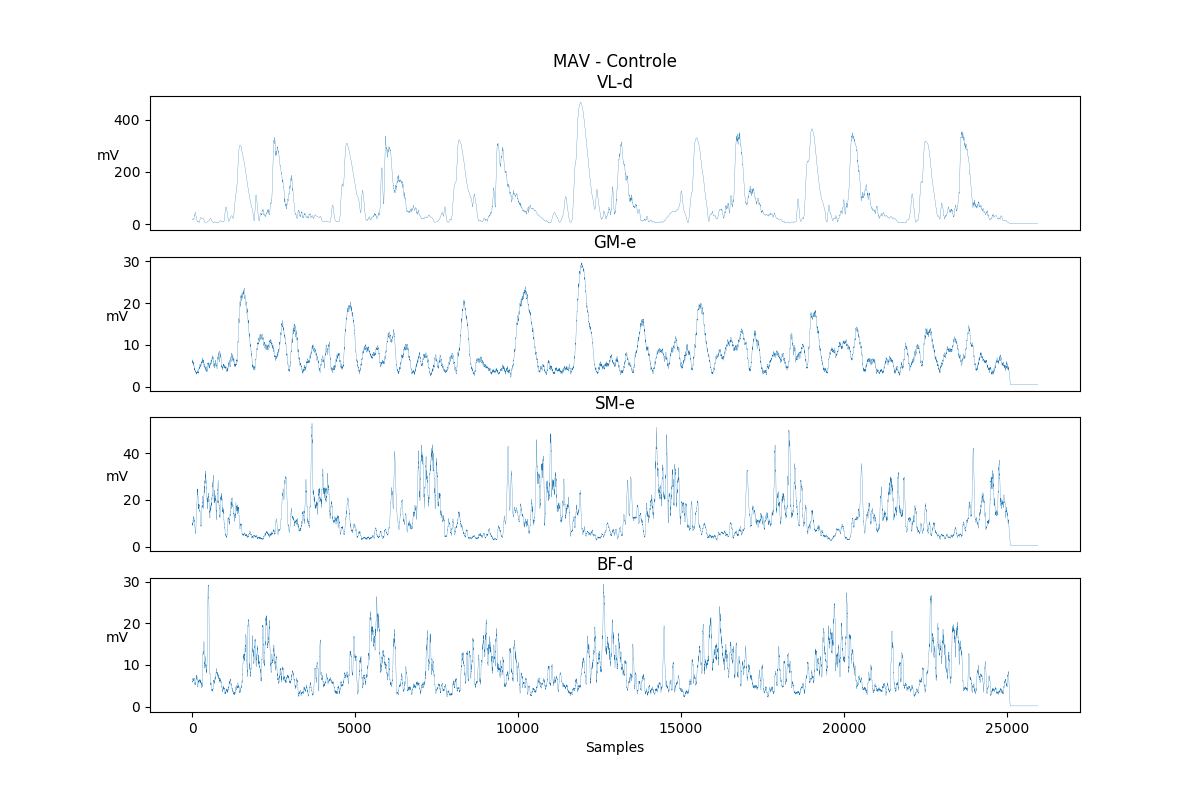

In [209]:
plot_emg("MAV - Controle",mav1)

In [210]:
var1 = f_var(df1a,50)
df1_v = pd.DataFrame(data=var1, columns=['VL', 'GM', 'SM', 'BF'])
df1_v.to_csv('./dados_filtrados/VAR - Controle.csv', sep='\t', encoding='utf-8')
df1_v.head()

VL         GM          SM         BF
0  277.921098  36.677951  138.710631  26.968819
1  277.759057  37.031127  134.476454  26.366683
2  278.316321  37.034397  153.930782  26.328249
3  279.441914  44.310470  156.334759  26.426736
4  276.794715  47.702429  158.960457  26.712591

<IPython.core.display.Javascript object>


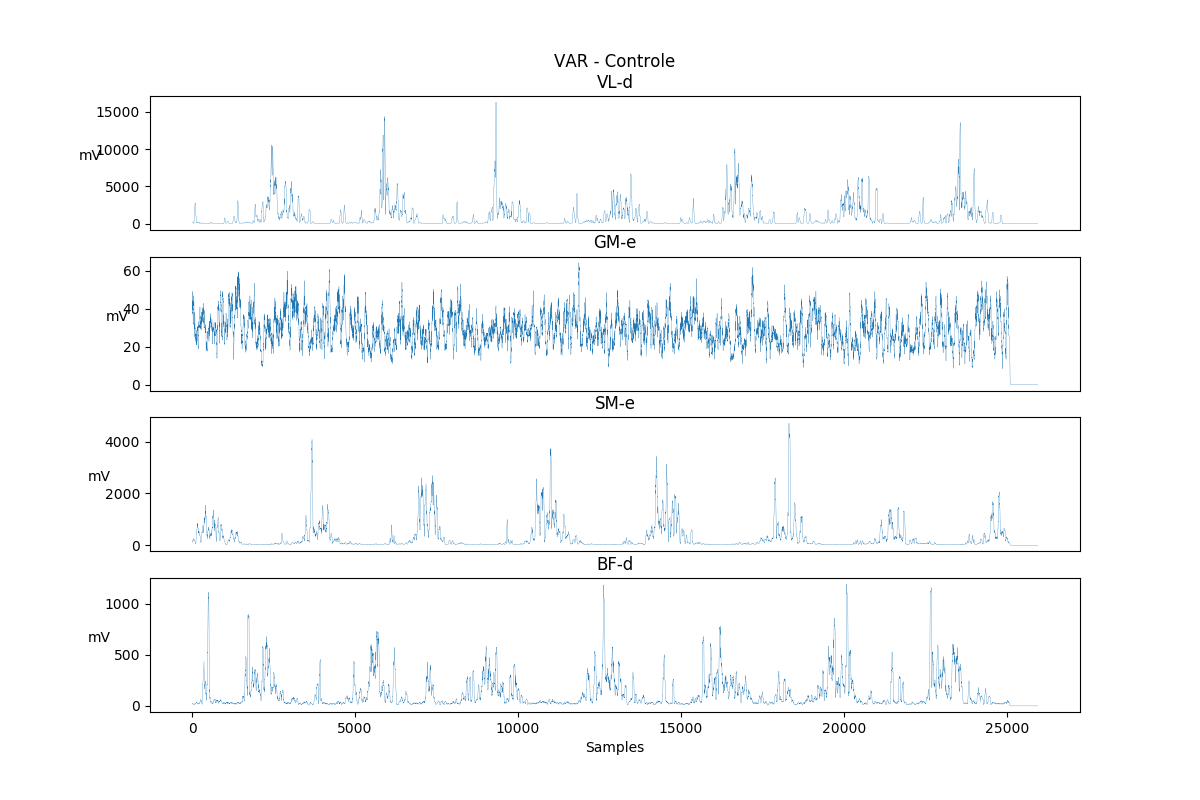

In [211]:
plot_emg("VAR - Controle",var1)

# Parkinson

In [186]:
import os
import pandas as pd

DATADIR = "gait_pks_avc_ctrl"
DATAFILE = "Francisco Alcantara - Dia 17.08.25 as 16.34.43.csv"

datafile = os.path.join(DATADIR, DATAFILE)
df2 = pd.read_csv(datafile, sep="\t", skiprows=1, header=None, names=['Time', 'VL', 'GM', 'SM', 
                                                                    'BF'])
df2.tail()

Time        VL        GM        SM        BF
23995  11.9975 -0.741445  0.743689  0.593305 -0.054895
23996  11.9980 -0.741445  0.743689  0.593305 -0.054895
23997  11.9985 -0.741445  0.743689  0.593305 -0.054895
23998  11.9990 -0.741445  0.743689  0.593305 -0.054895
23999  11.9995 -0.741445  0.743689  0.593305 -0.054895

<IPython.core.display.Javascript object>


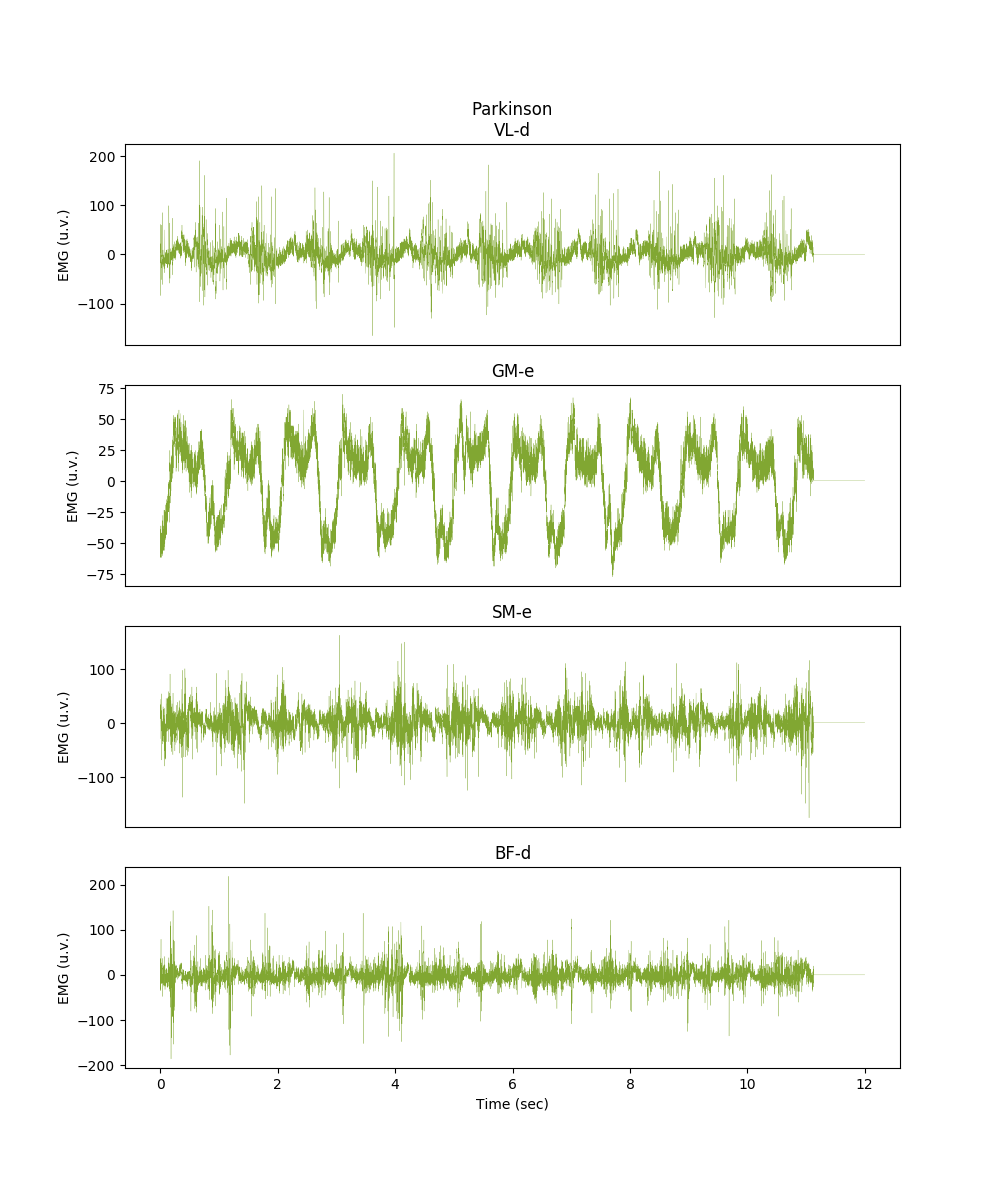

In [210]:
%matplotlib notebook
import matplotlib.pyplot as plt



fig2 = plt.figure()
ax1 = plt.subplot(4, 1, 1).xaxis.set_visible(False)
plt.plot(df2['Time'],df2['VL'], linewidth=0.2, color = '#81a732')
plt.xlabel('Sample')
plt.ylabel('EMG (u.v.)')
plt.title('Parkinson'+'\nVL-d')

ax2 = plt.subplot(4, 1, 2).xaxis.set_visible(False)
plt.plot(df2['Time'],df2['GM'], linewidth=0.2, color = '#81a732')
#plt.xlabel('Sample')
#plt.ylabel('mV')
plt.title('GM-e')
plt.ylabel('EMG (u.v.)')


ax3 = plt.subplot(4, 1, 3).xaxis.set_visible(False)
plt.plot(df2['Time'],df2['SM'], linewidth=0.2, color = '#81a732')
#plt.xlabel('Sample')
#plt.ylabel('mV')
plt.title('SM-e')
plt.ylabel('EMG (u.v.)')

            
ax4 = plt.subplot(4, 1, 4)
plt.plot(df2['Time'],df2['BF'], linewidth=0.2, color = '#81a732')
plt.xlabel('Time (sec)')
plt.title('BF-d')
plt.ylabel('EMG (u.v.)')

fig2.set_size_inches(w=10,h=12)
fig2.savefig('./gait_pks_avc_ctrl/parkinson.png')

<IPython.core.display.Javascript object>


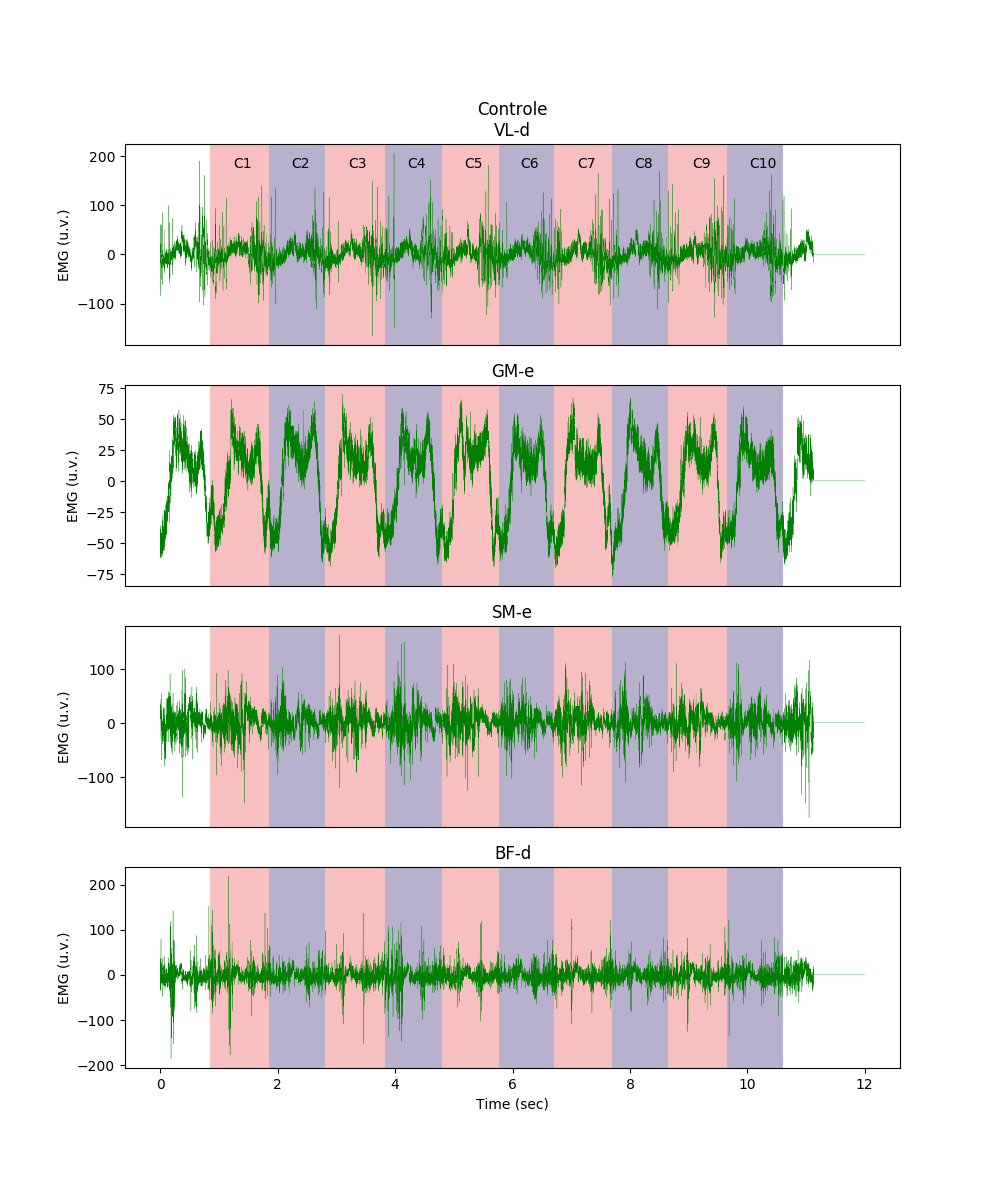

In [191]:
###### %matplotlib notebook
import matplotlib.pyplot as plt



fig1 = plt.figure()
ax1 = plt.subplot(4, 1, 1).xaxis.set_visible(False)
plt.plot(df2['Time'],df2['VL'], linewidth=0.2, color = '#008000')
plt.xlabel('Sample')
plt.ylabel('EMG (u.v.)')
plt.title('Controle'+'\nVL-d')

plt.axvspan(0.85, 1.85, facecolor='#F08080', alpha=0.5)
plt.axvspan(1.85, 2.80, facecolor='#70659e', alpha=0.5)
plt.axvspan(2.80, 3.82, facecolor='#F08080', alpha=0.5)
plt.axvspan(3.82, 4.80, facecolor='#70659e', alpha=0.5)
plt.axvspan(4.80, 5.77, facecolor='#F08080', alpha=0.5)
plt.axvspan(5.77, 6.70, facecolor='#70659e', alpha=0.5)
plt.axvspan(6.70, 7.70, facecolor='#F08080', alpha=0.5)
plt.axvspan(7.70, 8.65, facecolor='#70659e', alpha=0.5)
plt.axvspan(8.65, 9.66, facecolor='#F08080', alpha=0.5)
plt.axvspan(9.66, 10.60, facecolor='#70659e', alpha=0.5)

plt.annotate('C1', xy=(((0.85+1.85)/2-0.1), df2['VL'][2000:].max()*.85))  
plt.annotate('C2', xy=(((1.85+2.80)/2-0.1), df2['VL'][2000:].max()*.85))
plt.annotate('C3', xy=(((2.80+3.82)/2-0.1), df2['VL'][2000:].max()*.85))
plt.annotate('C4', xy=(((3.82+4.80)/2-0.1), df2['VL'][2000:].max()*.85))
plt.annotate('C5', xy=(((4.80+5.77)/2-0.1), df2['VL'][2000:].max()*.85))
plt.annotate('C6', xy=(((5.77+6.70)/2-0.1), df2['VL'][2000:].max()*.85))
plt.annotate('C7', xy=(((6.70+7.70)/2-0.1), df2['VL'][2000:].max()*.85))
plt.annotate('C8', xy=(((7.70+8.65)/2-0.1), df2['VL'][2000:].max()*.85))
plt.annotate('C9', xy=(((8.65+9.66)/2-0.1), df2['VL'][2000:].max()*.85))
plt.annotate('C10', xy=(((9.66+10.60)/2-0.1), df2['VL'][2000:].max()*.85))

ax2 = plt.subplot(4, 1, 2).xaxis.set_visible(False)
plt.plot(df2['Time'],df2['GM'], linewidth=0.2, color = '#008000')
#plt.xlabel('Sample')
#plt.ylabel('mV')
plt.title('GM-e')
plt.ylabel('EMG (u.v.)')

plt.axvspan(0.85, 1.85, facecolor='#F08080', alpha=0.5)
plt.axvspan(1.85, 2.80, facecolor='#70659e', alpha=0.5)
plt.axvspan(2.80, 3.82, facecolor='#F08080', alpha=0.5)
plt.axvspan(3.82, 4.80, facecolor='#70659e', alpha=0.5)
plt.axvspan(4.80, 5.77, facecolor='#F08080', alpha=0.5)
plt.axvspan(5.77, 6.70, facecolor='#70659e', alpha=0.5)
plt.axvspan(6.70, 7.70, facecolor='#F08080', alpha=0.5)
plt.axvspan(7.70, 8.65, facecolor='#70659e', alpha=0.5)
plt.axvspan(8.65, 9.66, facecolor='#F08080', alpha=0.5)
plt.axvspan(9.66, 10.60, facecolor='#70659e', alpha=0.5)

ax3 = plt.subplot(4, 1, 3).xaxis.set_visible(False)
plt.plot(df2['Time'],df2['SM'], linewidth=0.2, color = '#008000')
#plt.xlabel('Sample')
#plt.ylabel('mV')
plt.title('SM-e')
plt.ylabel('EMG (u.v.)')

plt.axvspan(0.85, 1.85, facecolor='#F08080', alpha=0.5)
plt.axvspan(1.85, 2.80, facecolor='#70659e', alpha=0.5)
plt.axvspan(2.80, 3.82, facecolor='#F08080', alpha=0.5)
plt.axvspan(3.82, 4.80, facecolor='#70659e', alpha=0.5)
plt.axvspan(4.80, 5.77, facecolor='#F08080', alpha=0.5)
plt.axvspan(5.77, 6.70, facecolor='#70659e', alpha=0.5)
plt.axvspan(6.70, 7.70, facecolor='#F08080', alpha=0.5)
plt.axvspan(7.70, 8.65, facecolor='#70659e', alpha=0.5)
plt.axvspan(8.65, 9.66, facecolor='#F08080', alpha=0.5)
plt.axvspan(9.66, 10.60, facecolor='#70659e', alpha=0.5)
            
ax4 = plt.subplot(4, 1, 4)
plt.plot(df2['Time'],df2['BF'], linewidth=0.2, color = '#008000')
plt.xlabel('Time (sec)')
plt.title('BF-d')
plt.ylabel('EMG (u.v.)')

plt.axvspan(0.85, 1.85, facecolor='#F08080', alpha=0.5)
plt.axvspan(1.85, 2.80, facecolor='#70659e', alpha=0.5)
plt.axvspan(2.80, 3.82, facecolor='#F08080', alpha=0.5)
plt.axvspan(3.82, 4.80, facecolor='#70659e', alpha=0.5)
plt.axvspan(4.80, 5.77, facecolor='#F08080', alpha=0.5)
plt.axvspan(5.77, 6.70, facecolor='#70659e', alpha=0.5)
plt.axvspan(6.70, 7.70, facecolor='#F08080', alpha=0.5)
plt.axvspan(7.70, 8.65, facecolor='#70659e', alpha=0.5)
plt.axvspan(8.65, 9.66, facecolor='#F08080', alpha=0.5)
plt.axvspan(9.66, 10.60, facecolor='#70659e', alpha=0.5)

fig1.set_size_inches(w=10,h=12)
fig1.savefig('./graphs/parkinson.png')

In [249]:
df2['VL'] = filter_signal(df2['VL'], low_pass=10)
df2['GM'] = filter_signal(df2['GM'], low_pass=10)
df2['SM'] = filter_signal(df2['SM'], low_pass=10)
df2['BF'] = filter_signal(df2['BF'], low_pass=10)

<IPython.core.display.Javascript object>


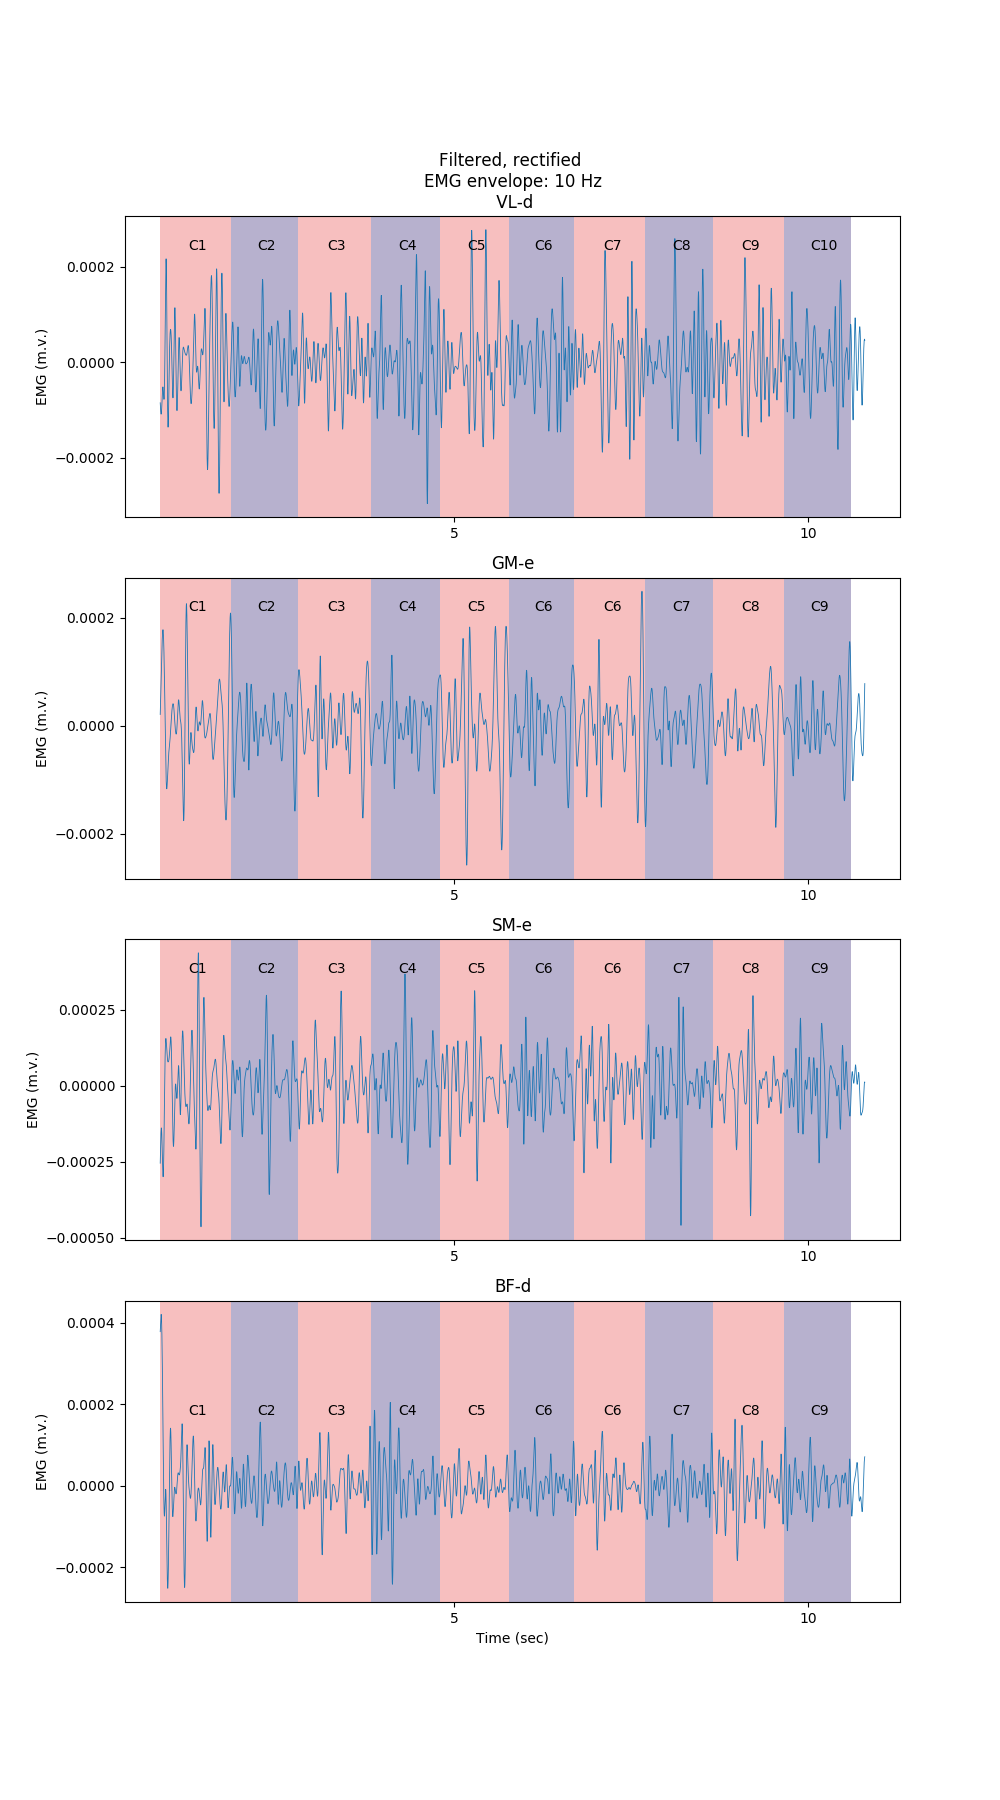

In [261]:
fig = plt.figure()
#plt.subplot(4, 1, 1).xaxis.set_visible(False)
plt.subplot(4, 1, 1).set_title('Filtered, rectified ' + '\n' + 'EMG envelope: ' + str(int(10)) + ' Hz' + '\n VL-d')
plt.plot(df2['Time'][1700:-2400], df2['VL'][1700:-2400], linewidth=0.6)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.axvspan(0.85, 1.85, facecolor='#F08080', alpha=0.5)
plt.axvspan(1.85, 2.80, facecolor='#70659e', alpha=0.5)
plt.axvspan(2.80, 3.82, facecolor='#F08080', alpha=0.5)
plt.axvspan(3.82, 4.80, facecolor='#70659e', alpha=0.5)
plt.axvspan(4.80, 5.77, facecolor='#F08080', alpha=0.5)
plt.axvspan(5.77, 6.70, facecolor='#70659e', alpha=0.5)
plt.axvspan(6.70, 7.70, facecolor='#F08080', alpha=0.5)
plt.axvspan(7.70, 8.65, facecolor='#70659e', alpha=0.5)
plt.axvspan(8.65, 9.66, facecolor='#F08080', alpha=0.5)
plt.axvspan(9.66, 10.60, facecolor='#70659e', alpha=0.5)

plt.annotate('C1', xy=(((0.85+1.85)/2-0.1), df2['VL'][2000:].max()*.85))  
plt.annotate('C2', xy=(((1.85+2.80)/2-0.1), df2['VL'][2000:].max()*.85))
plt.annotate('C3', xy=(((2.80+3.82)/2-0.1), df2['VL'][2000:].max()*.85))
plt.annotate('C4', xy=(((3.82+4.80)/2-0.1), df2['VL'][2000:].max()*.85))
plt.annotate('C5', xy=(((4.80+5.77)/2-0.1), df2['VL'][2000:].max()*.85))
plt.annotate('C6', xy=(((5.77+6.70)/2-0.1), df2['VL'][2000:].max()*.85))
plt.annotate('C7', xy=(((6.70+7.70)/2-0.1), df2['VL'][2000:].max()*.85))
plt.annotate('C8', xy=(((7.70+8.65)/2-0.1), df2['VL'][2000:].max()*.85))
plt.annotate('C9', xy=(((8.65+9.66)/2-0.1), df2['VL'][2000:].max()*.85))
plt.annotate('C10', xy=(((9.66+10.60)/2-0.1), df2['VL'][2000:].max()*.85))
plt.ylabel('EMG (m.v.)')
#plt.xlabel('Time (sec)')


plt.subplot(4, 1, 2).set_title('GM-e')
plt.plot(df2['Time'][1700:-2400], df2['GM'][1700:-2400], linewidth=0.6)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.axvspan(0.85, 1.85, facecolor='#F08080', alpha=0.5)
plt.axvspan(1.85, 2.80, facecolor='#70659e', alpha=0.5)
plt.axvspan(2.80, 3.82, facecolor='#F08080', alpha=0.5)
plt.axvspan(3.82, 4.80, facecolor='#70659e', alpha=0.5)
plt.axvspan(4.80, 5.77, facecolor='#F08080', alpha=0.5)
plt.axvspan(5.77, 6.70, facecolor='#70659e', alpha=0.5)
plt.axvspan(6.70, 7.70, facecolor='#F08080', alpha=0.5)
plt.axvspan(7.70, 8.65, facecolor='#70659e', alpha=0.5)
plt.axvspan(8.65, 9.66, facecolor='#F08080', alpha=0.5)
plt.axvspan(9.66, 10.60, facecolor='#70659e', alpha=0.5)

plt.annotate('C1', xy=(((0.85+1.85)/2-0.1), df2['GM'][2000:].max()*.85))  
plt.annotate('C2', xy=(((1.85+2.80)/2-0.1), df2['GM'][2000:].max()*.85))
plt.annotate('C3', xy=(((2.80+3.82)/2-0.1), df2['GM'][2000:].max()*.85))
plt.annotate('C4', xy=(((3.82+4.80)/2-0.1), df2['GM'][2000:].max()*.85))
plt.annotate('C5', xy=(((4.80+5.77)/2-0.1), df2['GM'][2000:].max()*.85))
plt.annotate('C6', xy=(((5.77+6.70)/2-0.1), df2['GM'][2000:].max()*.85))
plt.annotate('C6', xy=(((6.70+7.70)/2-0.1), df2['GM'][2000:].max()*.85))
plt.annotate('C7', xy=(((7.70+8.65)/2-0.1), df2['GM'][2000:].max()*.85))
plt.annotate('C8', xy=(((8.65+9.66)/2-0.1), df2['GM'][2000:].max()*.85))
plt.annotate('C9', xy=(((9.66+10.60)/2-0.1), df2['GM'][2000:].max()*.85))
plt.ylabel('EMG (m.v.)')
#plt.xlabel('Time (sec)')


plt.subplot(4, 1, 3).set_title('SM-e')
plt.plot(df2['Time'][1700:-2400], df2['SM'][1700:-2400], linewidth=0.6)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.axvspan(0.85, 1.85, facecolor='#F08080', alpha=0.5)
plt.axvspan(1.85, 2.80, facecolor='#70659e', alpha=0.5)
plt.axvspan(2.80, 3.82, facecolor='#F08080', alpha=0.5)
plt.axvspan(3.82, 4.80, facecolor='#70659e', alpha=0.5)
plt.axvspan(4.80, 5.77, facecolor='#F08080', alpha=0.5)
plt.axvspan(5.77, 6.70, facecolor='#70659e', alpha=0.5)
plt.axvspan(6.70, 7.70, facecolor='#F08080', alpha=0.5)
plt.axvspan(7.70, 8.65, facecolor='#70659e', alpha=0.5)
plt.axvspan(8.65, 9.66, facecolor='#F08080', alpha=0.5)
plt.axvspan(9.66, 10.60, facecolor='#70659e', alpha=0.5)

plt.annotate('C1', xy=(((0.85+1.85)/2-0.1), df2['SM'][2000:].max()*.85))  
plt.annotate('C2', xy=(((1.85+2.80)/2-0.1), df2['SM'][2000:].max()*.85))
plt.annotate('C3', xy=(((2.80+3.82)/2-0.1), df2['SM'][2000:].max()*.85))
plt.annotate('C4', xy=(((3.82+4.80)/2-0.1), df2['SM'][2000:].max()*.85))
plt.annotate('C5', xy=(((4.80+5.77)/2-0.1), df2['SM'][2000:].max()*.85))
plt.annotate('C6', xy=(((5.77+6.70)/2-0.1), df2['SM'][2000:].max()*.85))
plt.annotate('C6', xy=(((6.70+7.70)/2-0.1), df2['SM'][2000:].max()*.85))
plt.annotate('C7', xy=(((7.70+8.65)/2-0.1), df2['SM'][2000:].max()*.85))
plt.annotate('C8', xy=(((8.65+9.66)/2-0.1), df2['SM'][2000:].max()*.85))
plt.annotate('C9', xy=(((9.66+10.60)/2-0.1), df2['SM'][2000:].max()*.85))
plt.ylabel('EMG (m.v.)')
#plt.xlabel('Time (sec)')


plt.subplot(4, 1, 4).set_title('BF-d')
plt.plot(df2['Time'][1700:-2400], df2['BF'][1700:-2400], linewidth=0.6)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.axvspan(0.85, 1.85, facecolor='#F08080', alpha=0.5)
plt.axvspan(1.85, 2.80, facecolor='#70659e', alpha=0.5)
plt.axvspan(2.80, 3.82, facecolor='#F08080', alpha=0.5)
plt.axvspan(3.82, 4.80, facecolor='#70659e', alpha=0.5)
plt.axvspan(4.80, 5.77, facecolor='#F08080', alpha=0.5)
plt.axvspan(5.77, 6.70, facecolor='#70659e', alpha=0.5)
plt.axvspan(6.70, 7.70, facecolor='#F08080', alpha=0.5)
plt.axvspan(7.70, 8.65, facecolor='#70659e', alpha=0.5)
plt.axvspan(8.65, 9.66, facecolor='#F08080', alpha=0.5)
plt.axvspan(9.66, 10.60, facecolor='#70659e', alpha=0.5)

plt.annotate('C1', xy=(((0.85+1.85)/2-0.1), df2['BF'][2000:].max()*.85))  
plt.annotate('C2', xy=(((1.85+2.80)/2-0.1), df2['BF'][2000:].max()*.85))
plt.annotate('C3', xy=(((2.80+3.82)/2-0.1), df2['BF'][2000:].max()*.85))
plt.annotate('C4', xy=(((3.82+4.80)/2-0.1), df2['BF'][2000:].max()*.85))
plt.annotate('C5', xy=(((4.80+5.77)/2-0.1), df2['BF'][2000:].max()*.85))
plt.annotate('C6', xy=(((5.77+6.70)/2-0.1), df2['BF'][2000:].max()*.85))
plt.annotate('C6', xy=(((6.70+7.70)/2-0.1), df2['BF'][2000:].max()*.85))
plt.annotate('C7', xy=(((7.70+8.65)/2-0.1), df2['BF'][2000:].max()*.85))
plt.annotate('C8', xy=(((8.65+9.66)/2-0.1), df2['BF'][2000:].max()*.85))
plt.annotate('C9', xy=(((9.66+10.60)/2-0.1), df2['BF'][2000:].max()*.85))
plt.ylabel('EMG (m.v.)')
plt.xlabel('Time (sec)')

fig.set_size_inches(w=10,h=18)
fig2.savefig('./gait_pks_avc_ctrl/parkinson_filtrado.png')

In [192]:
# Sinal cru
df2a = df2.as_matrix(columns=df2.columns[1:])

In [260]:
rms2 = rms(df1a,50)
df2_r = pd.DataFrame(data=rms2, columns=['VL', 'GM', 'SM', 'BF'])
df2_r.to_csv('./dados_filtrados/RMS - Parkinson.csv', sep='\t', encoding='utf-8')
df2_r.head()

VL        GM         SM        BF
0  21.462990  7.842507  11.912354  7.048858
1  21.370939  7.793038  11.686546  6.967639
2  21.472195  7.757653  12.430891  7.003273
3  21.640524  8.049085  12.503572  7.029571
4  21.886766  8.400888  12.628603  7.107880

<IPython.core.display.Javascript object>


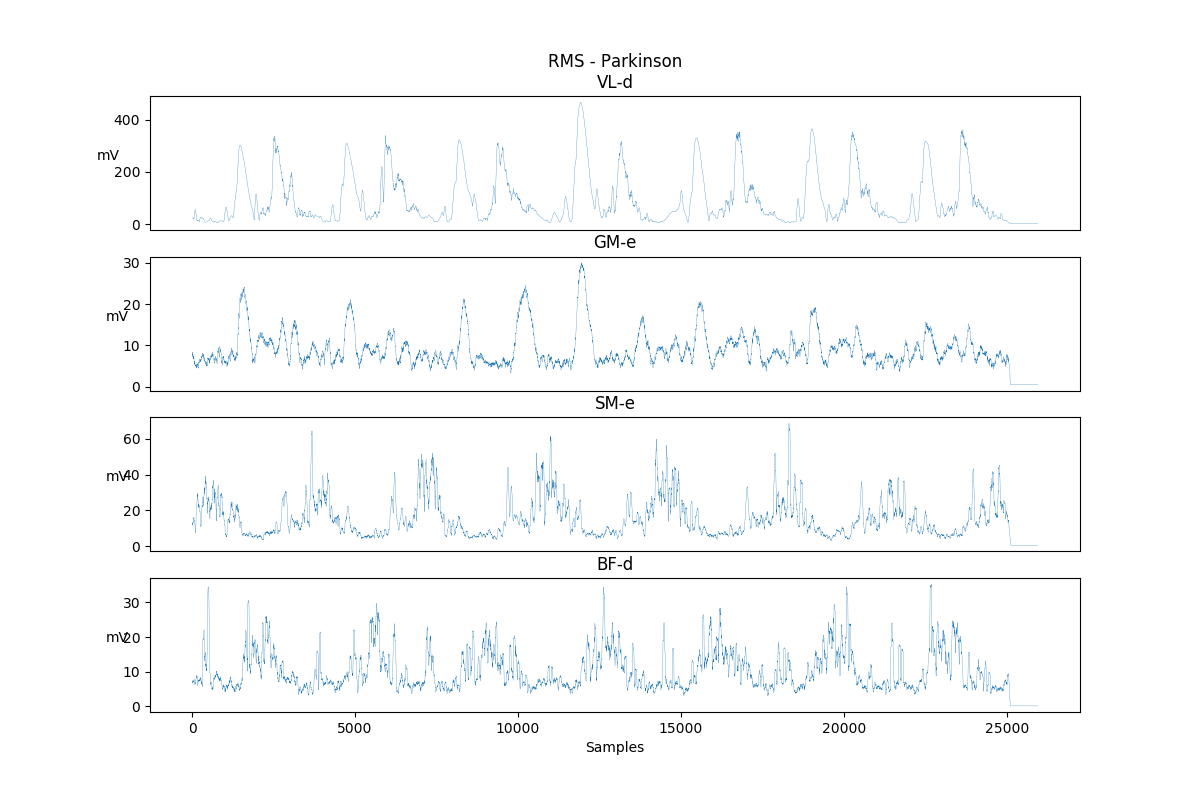

In [200]:
plot_emg("RMS - Parkinson",rms2)

In [204]:
mav2 = mav(df1a,50)
df2_m = pd.DataFrame(data=mav2, columns=['VL', 'GM', 'SM', 'BF'])
df2_m.to_csv('./dados_filtrados/MAV - Parkinson.csv', sep='\t', encoding='utf-8')
df2_m.head()

VL        GM        SM        BF
0  16.093840  6.073630  9.491810  5.992891
1  15.953266  5.959259  9.176762  5.936297
2  16.093840  5.902074  9.707429  5.992891
3  16.318759  6.188000  9.758857  6.021187
4  16.767266  6.445333  9.838476  6.106078

<IPython.core.display.Javascript object>


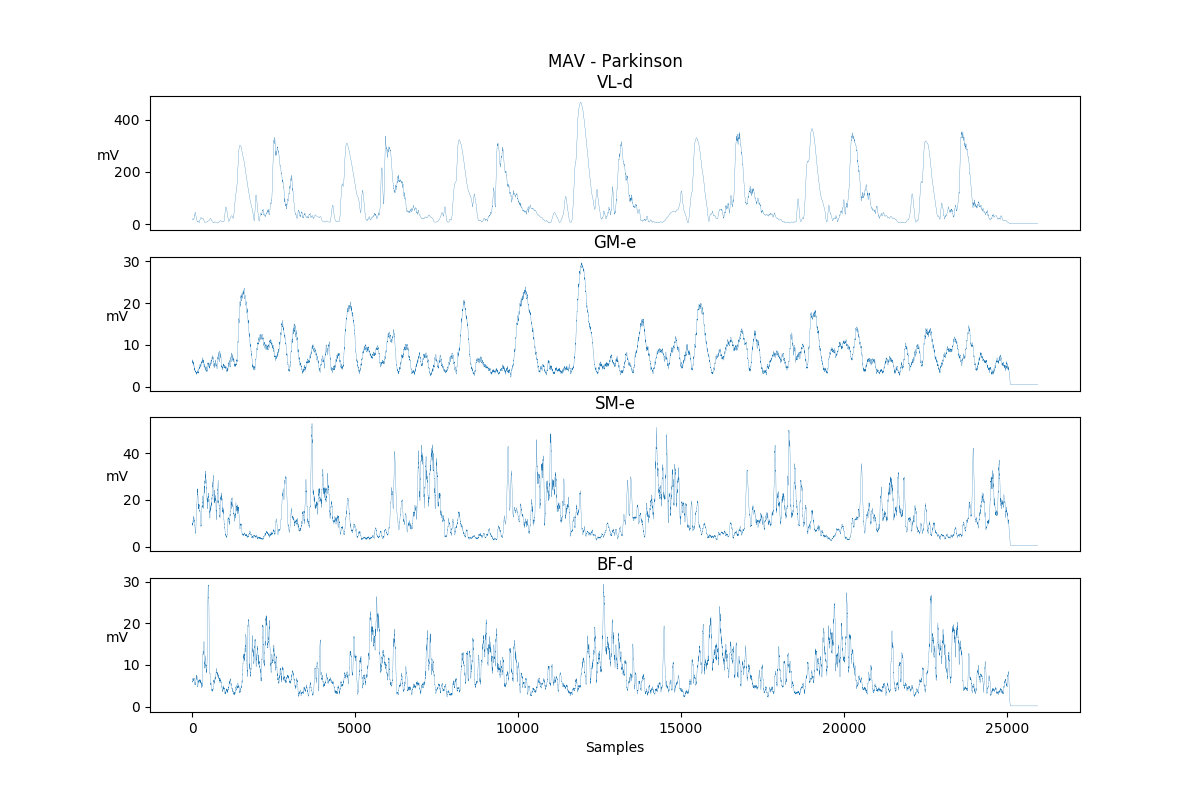

In [201]:
plot_emg("MAV - Parkinson",mav2)

In [203]:
var2 = f_var(df1a,50)
df2_v = pd.DataFrame(data=var2, columns=['VL', 'GM', 'SM', 'BF'])
df2_v.to_csv('./dados_filtrados/VAR - Parkinson.csv', sep='\t', encoding='utf-8')
df2_v.head()

VL         GM          SM         BF
0  277.921098  36.677951  138.710631  26.968819
1  277.759057  37.031127  134.476454  26.366683
2  278.316321  37.034397  153.930782  26.328249
3  279.441914  44.310470  156.334759  26.426736
4  276.794715  47.702429  158.960457  26.712591

<IPython.core.display.Javascript object>


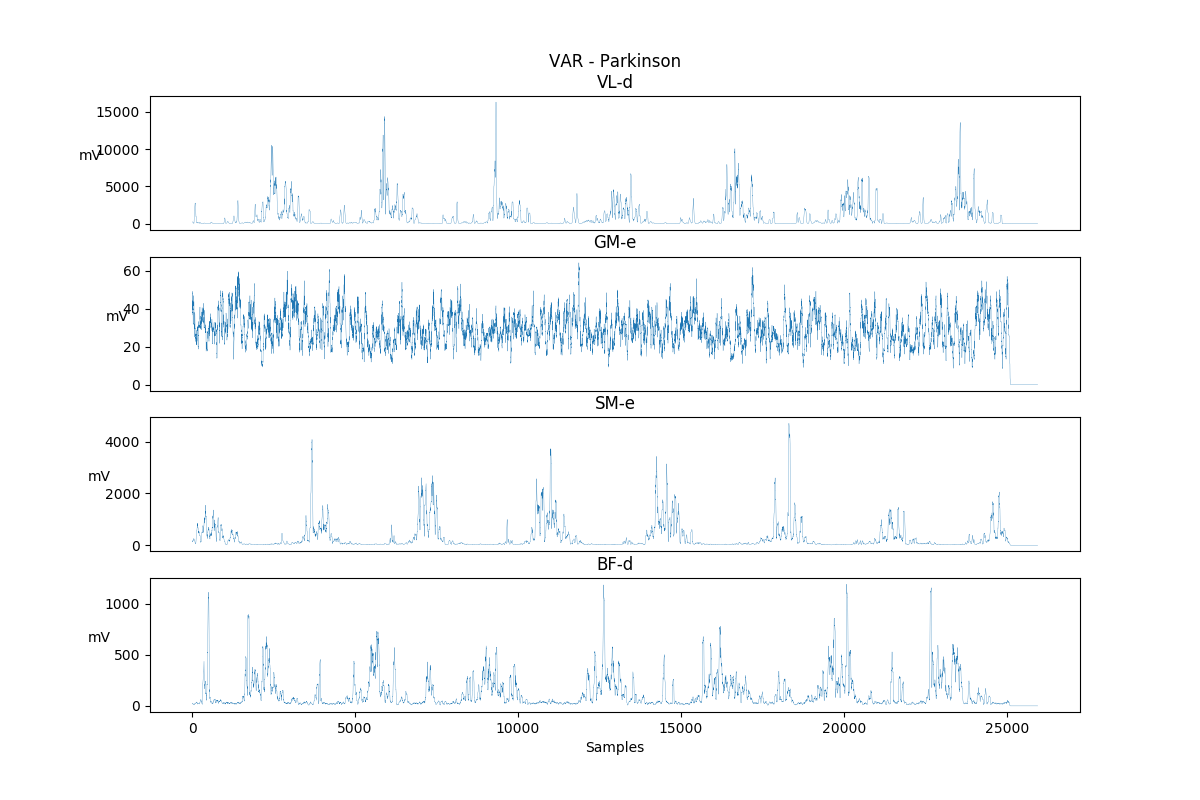

In [202]:
plot_emg("VAR - Parkinson",var2)

# AVC

In [255]:
import os
import pandas as pd

DATADIR = "gait_pks_avc_ctrl"
DATAFILE = "Uziel Pino Guardiola - Dia 17.07.18 as 11.48.33.csv"

datafile = os.path.join(DATADIR, DATAFILE)
df3 = pd.read_csv(datafile, sep="\t", skiprows=1, skipfooter=144, header=None, names=['Time', 'VL', 'GM', 'SM', 
                                                                    'BF'])
df3.head()

/home/collumbus/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


Time           VL         GM         SM         BF
0  0.0000 -4084.187413   3.522857 -65.834966 -53.454545
1  0.0005 -4078.559441  13.482857 -74.261512 -52.045455
2  0.0010 -4081.373427  17.751429 -72.857088 -63.318182
3  0.0015 -4078.559441  19.174286 -72.857088 -66.136364
4  0.0020 -4079.966434  20.597143 -72.857088 -57.681818

<IPython.core.display.Javascript object>


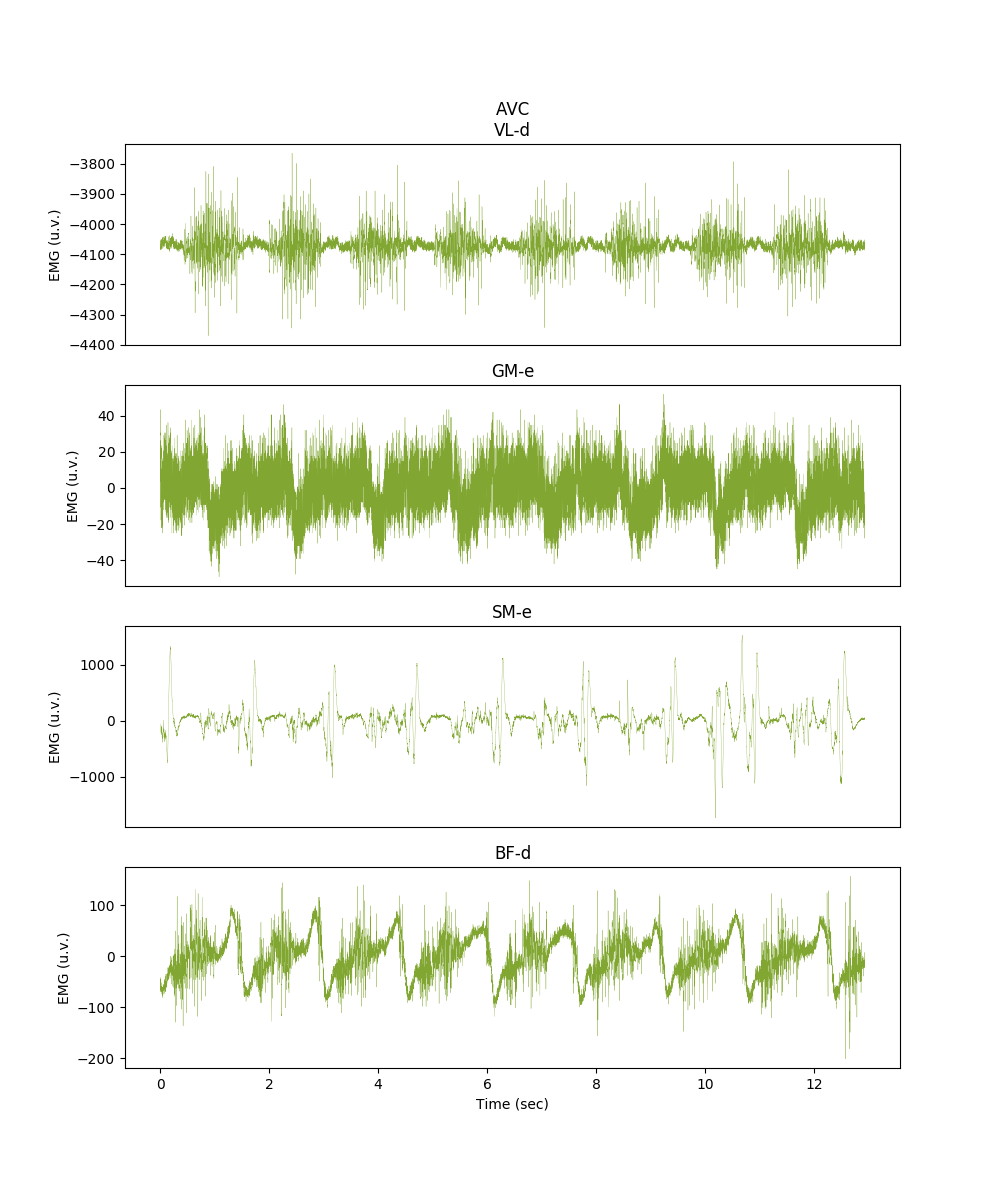

In [266]:
%matplotlib notebook
import matplotlib.pyplot as plt



fig3 = plt.figure()
ax1 = plt.subplot(4, 1, 1).xaxis.set_visible(False)
plt.plot(df3['Time'],df3['VL'], linewidth=0.2, color = '#81a732')
plt.xlabel('Sample')
plt.ylabel('EMG (u.v.)')
plt.title('AVC'+'\nVL-d')

ax2 = plt.subplot(4, 1, 2).xaxis.set_visible(False)
plt.plot(df3['Time'],df3['GM'], linewidth=0.2, color = '#81a732')
#plt.xlabel('Sample')
#plt.ylabel('mV')
plt.title('GM-e')
plt.ylabel('EMG (u.v.)')


ax3 = plt.subplot(4, 1, 3).xaxis.set_visible(False)
plt.plot(df3['Time'],df3['SM'], linewidth=0.2, color = '#81a732')
#plt.xlabel('Sample')
#plt.ylabel('mV')
plt.title('SM-e')
plt.ylabel('EMG (u.v.)')

            
ax4 = plt.subplot(4, 1, 4)
plt.plot(df3['Time'],df3['BF'], linewidth=0.2, color = '#81a732')
plt.xlabel('Time (sec)')
plt.title('BF-d')
plt.ylabel('EMG (u.v.)')

fig3.set_size_inches(w=10,h=12)
fig3.savefig('./graphs/avc.png')

<IPython.core.display.Javascript object>


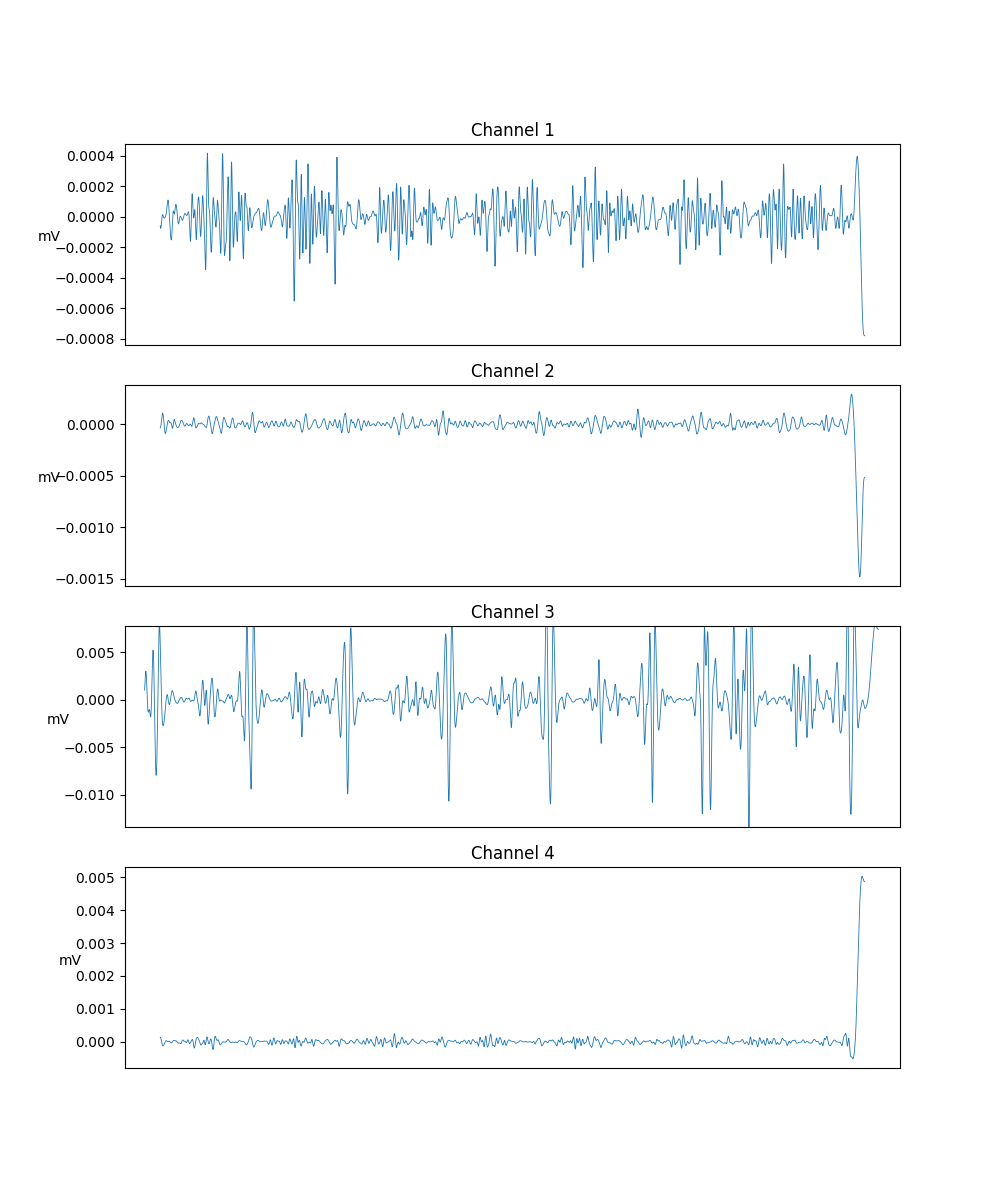

In [264]:
df3['VL'] = filter_signal(df3['VL'], low_pass=10)
df3['GM'] = filter_signal(df3['GM'], low_pass=10)
df3['SM'] = filter_signal(df3['SM'], low_pass=10)
df3['BF'] = filter_signal(df3['BF'], low_pass=10)

plot_fremgp(df3)

<IPython.core.display.Javascript object>


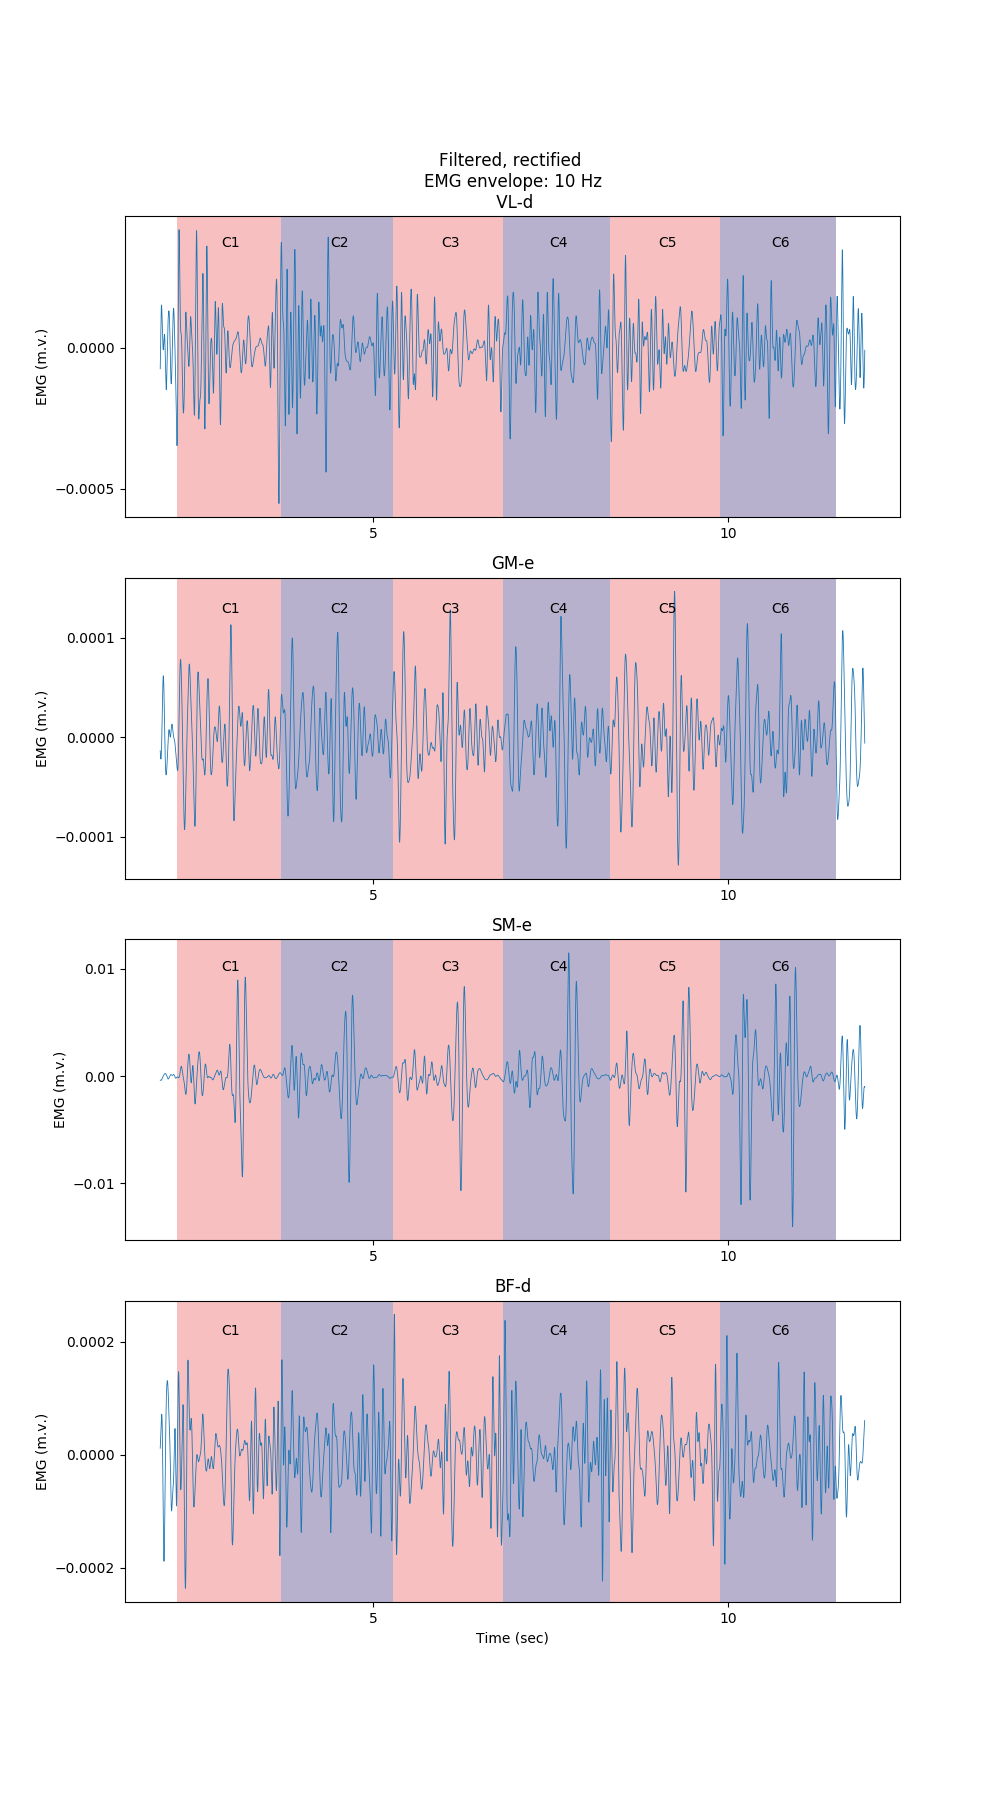

In [305]:
fig = plt.figure()
#plt.subplot(4, 1, 1).xaxis.set_visible(False)
plt.subplot(4, 1, 1).set_title('Filtered, rectified ' + '\n' + 'EMG envelope: ' + str(int(10)) + ' Hz' + '\n VL-d')
plt.plot(df3['Time'][4000:-2000], df3['VL'][4000:-2000], linewidth=0.6)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.axvspan(2.23, 3.70, facecolor='#F08080', alpha=0.5)
plt.axvspan(3.70, 5.28, facecolor='#70659e', alpha=0.5)
plt.axvspan(5.28, 6.83, facecolor='#F08080', alpha=0.5)
plt.axvspan(6.83, 8.34, facecolor='#70659e', alpha=0.5)
plt.axvspan(8.34, 9.89, facecolor='#F08080', alpha=0.5)
plt.axvspan(9.89, 11.52, facecolor='#70659e', alpha=0.5)

plt.annotate('C1', xy=(((2.23+3.70)/2-0.1), df3['VL'][4000:-2000].max()*.85))  
plt.annotate('C2', xy=(((3.70+5.28)/2-0.1), df3['VL'][4000:-2000].max()*.85))
plt.annotate('C3', xy=(((5.28+6.83)/2-0.1), df3['VL'][4000:-2000].max()*.85))
plt.annotate('C4', xy=(((6.83+8.34)/2-0.1), df3['VL'][4000:-2000].max()*.85))
plt.annotate('C5', xy=(((8.34+9.89)/2-0.1), df3['VL'][4000:-2000].max()*.85))
plt.annotate('C6', xy=(((9.89+11.52)/2-0.1), df3['VL'][4000:-2000].max()*.85))
#plt.annotate('C7', xy=((7*1.73+0.3), df3['VL'][2000:].max()*.85))
plt.ylabel('EMG (m.v.)')
#plt.xlabel('Time (sec)')


plt.subplot(4, 1, 2).set_title('GM-e')
plt.plot(df3['Time'][4000:-2000], df3['GM'][4000:-2000], linewidth=0.6)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.axvspan(2.23, 3.70, facecolor='#F08080', alpha=0.5)
plt.axvspan(3.70, 5.28, facecolor='#70659e', alpha=0.5)
plt.axvspan(5.28, 6.83, facecolor='#F08080', alpha=0.5)
plt.axvspan(6.83, 8.34, facecolor='#70659e', alpha=0.5)
plt.axvspan(8.34, 9.89, facecolor='#F08080', alpha=0.5)
plt.axvspan(9.89, 11.52, facecolor='#70659e', alpha=0.5)

plt.annotate('C1', xy=(((2.23+3.70)/2-0.1), df3['GM'][4000:-2000].max()*.85))  
plt.annotate('C2', xy=(((3.70+5.28)/2-0.1), df3['GM'][4000:-2000].max()*.85))
plt.annotate('C3', xy=(((5.28+6.83)/2-0.1), df3['GM'][4000:-2000].max()*.85))
plt.annotate('C4', xy=(((6.83+8.34)/2-0.1), df3['GM'][4000:-2000].max()*.85))
plt.annotate('C5', xy=(((8.34+9.89)/2-0.1), df3['GM'][4000:-2000].max()*.85))
plt.annotate('C6', xy=(((9.89+11.52)/2-0.1), df3['GM'][4000:-2000].max()*.85))
#plt.annotate('C7', xy=((7*1.73+0.3), df3['GM'][2000:].max()*.85))
plt.ylabel('EMG (m.v.)')
#plt.xlabel('Time (sec)')


plt.subplot(4, 1, 3).set_title('SM-e')
plt.plot(df3['Time'][4000:-2000], df3['SM'][4000:-2000], linewidth=0.6)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.axvspan(2.23, 3.70, facecolor='#F08080', alpha=0.5)
plt.axvspan(3.70, 5.28, facecolor='#70659e', alpha=0.5)
plt.axvspan(5.28, 6.83, facecolor='#F08080', alpha=0.5)
plt.axvspan(6.83, 8.34, facecolor='#70659e', alpha=0.5)
plt.axvspan(8.34, 9.89, facecolor='#F08080', alpha=0.5)
plt.axvspan(9.89, 11.52, facecolor='#70659e', alpha=0.5)

plt.annotate('C1', xy=(((2.23+3.70)/2-0.1), df3['SM'][4000:-2000].max()*.85))  
plt.annotate('C2', xy=(((3.70+5.28)/2-0.1), df3['SM'][4000:-2000].max()*.85))
plt.annotate('C3', xy=(((5.28+6.83)/2-0.1), df3['SM'][4000:-2000].max()*.85))
plt.annotate('C4', xy=(((6.83+8.34)/2-0.1), df3['SM'][4000:-2000].max()*.85))
plt.annotate('C5', xy=(((8.34+9.89)/2-0.1), df3['SM'][4000:-2000].max()*.85))
plt.annotate('C6', xy=(((9.89+11.52)/2-0.1), df3['SM'][4000:-2000].max()*.85))
#plt.annotate('C7', xy=((7*1.73+0.3), df3['SM'][2000:].max()*.85))
plt.ylabel('EMG (m.v.)')
#plt.xlabel('Time (sec)')


plt.subplot(4, 1, 4).set_title('BF-d')
plt.plot(df3['Time'][4000:-2000], df3['BF'][4000:-2000], linewidth=0.6)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.axvspan(2.23, 3.70, facecolor='#F08080', alpha=0.5)
plt.axvspan(3.70, 5.28, facecolor='#70659e', alpha=0.5)
plt.axvspan(5.28, 6.83, facecolor='#F08080', alpha=0.5)
plt.axvspan(6.83, 8.34, facecolor='#70659e', alpha=0.5)
plt.axvspan(8.34, 9.89, facecolor='#F08080', alpha=0.5)
plt.axvspan(9.89, 11.52, facecolor='#70659e', alpha=0.5)

plt.annotate('C1', xy=(((2.23+3.70)/2-0.1), df3['BF'][4000:-2000].max()*.85))  
plt.annotate('C2', xy=(((3.70+5.28)/2-0.1), df3['BF'][4000:-2000].max()*.85))
plt.annotate('C3', xy=(((5.28+6.83)/2-0.1), df3['BF'][4000:-2000].max()*.85))
plt.annotate('C4', xy=(((6.83+8.34)/2-0.1), df3['BF'][4000:-2000].max()*.85))
plt.annotate('C5', xy=(((8.34+9.89)/2-0.1), df3['BF'][4000:-2000].max()*.85))
plt.annotate('C6', xy=(((9.89+11.52)/2-0.1), df3['BF'][4000:-2000].max()*.85))
#plt.annotate('C7', xy=((7*1.73+0.3), df3['BF'][2000:].max()*.85))
plt.ylabel('EMG (m.v.)')
plt.xlabel('Time (sec)')

fig.set_size_inches(w=10,h=18)


In [257]:
# Sinal cru
df3a = df3.as_matrix(columns=df3.columns[1:])

In [259]:
rms3 = rms(df1a,50)
df3_r = pd.DataFrame(data=rms3, columns=['VL', 'GM', 'SM', 'BF'])
df3_r.to_csv('./dados_filtrados/RMS - AVC.csv', sep='\t', encoding='utf-8')
df3_r.head()

VL        GM         SM        BF
0  21.462990  7.842507  11.912354  7.048858
1  21.370939  7.793038  11.686546  6.967639
2  21.472195  7.757653  12.430891  7.003273
3  21.640524  8.049085  12.503572  7.029571
4  21.886766  8.400888  12.628603  7.107880

<IPython.core.display.Javascript object>


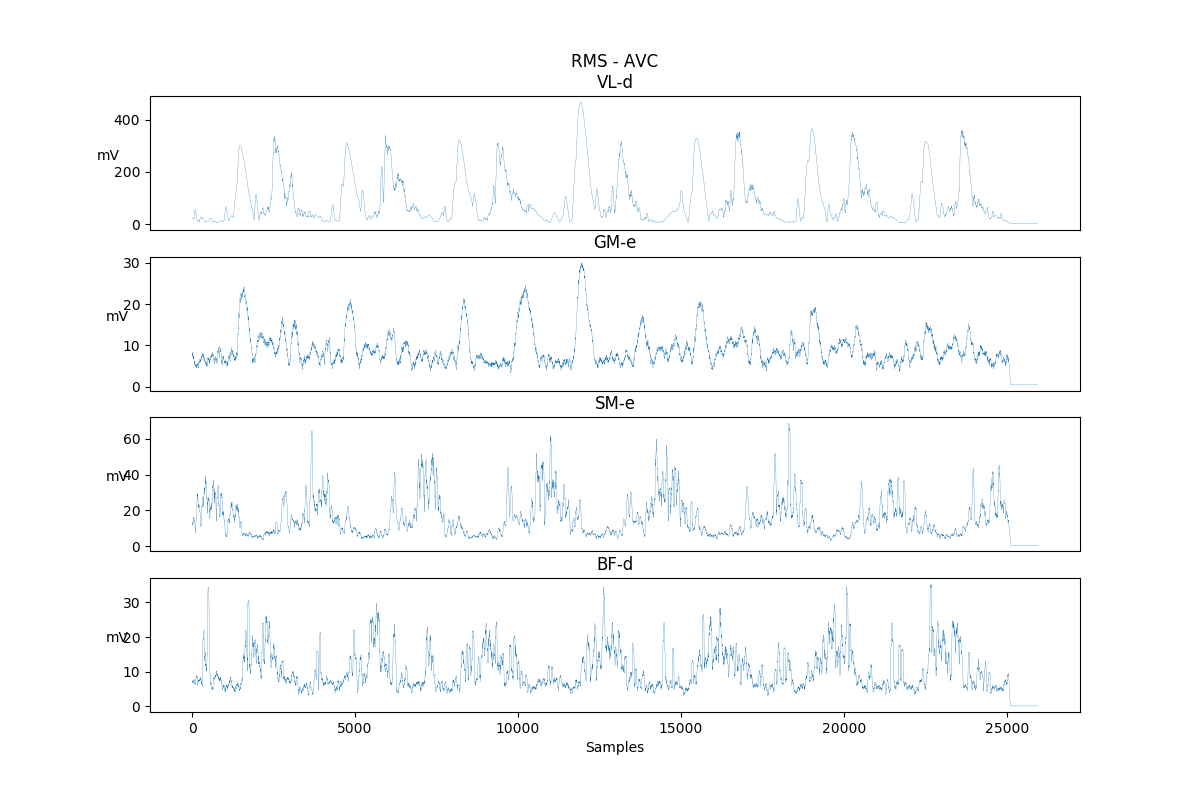

In [261]:
plot_emg("RMS - AVC",rms3)

In [262]:
mav3 = mav(df1a,50)
df3_m = pd.DataFrame(data=mav3, columns=['VL', 'GM', 'SM', 'BF'])
df3_m.to_csv('./dados_filtrados/MAV - AVC.csv', sep='\t', encoding='utf-8')
df3_m.head()

VL        GM        SM        BF
0  16.093840  6.073630  9.491810  5.992891
1  15.953266  5.959259  9.176762  5.936297
2  16.093840  5.902074  9.707429  5.992891
3  16.318759  6.188000  9.758857  6.021187
4  16.767266  6.445333  9.838476  6.106078

<IPython.core.display.Javascript object>


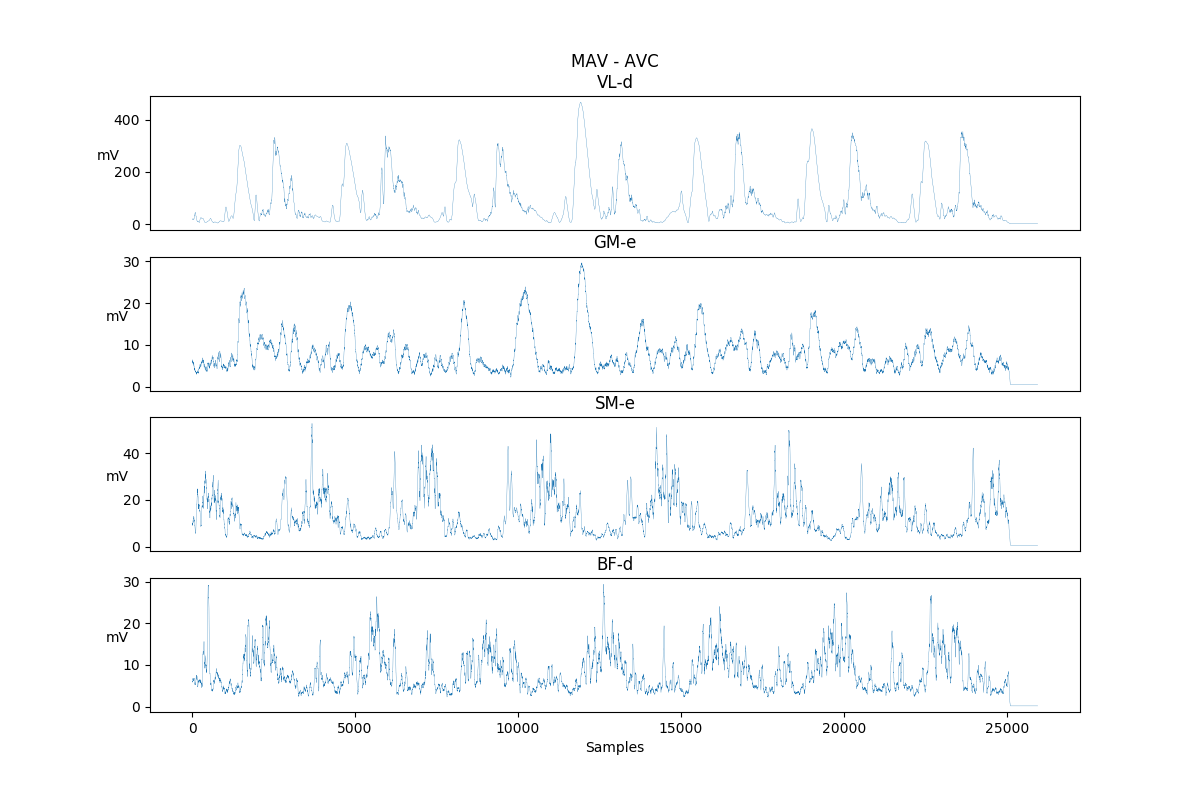

In [263]:
plot_emg("MAV - AVC",mav3)

In [264]:
var3 = f_var(df1a,50)
df3_v = pd.DataFrame(data=var3, columns=['VL', 'GM', 'SM', 'BF'])
df3_v.to_csv('./dados_filtrados/VAR - AVC.csv', sep='\t', encoding='utf-8')
df3_v.head()

VL         GM          SM         BF
0  277.921098  36.677951  138.710631  26.968819
1  277.759057  37.031127  134.476454  26.366683
2  278.316321  37.034397  153.930782  26.328249
3  279.441914  44.310470  156.334759  26.426736
4  276.794715  47.702429  158.960457  26.712591

<IPython.core.display.Javascript object>


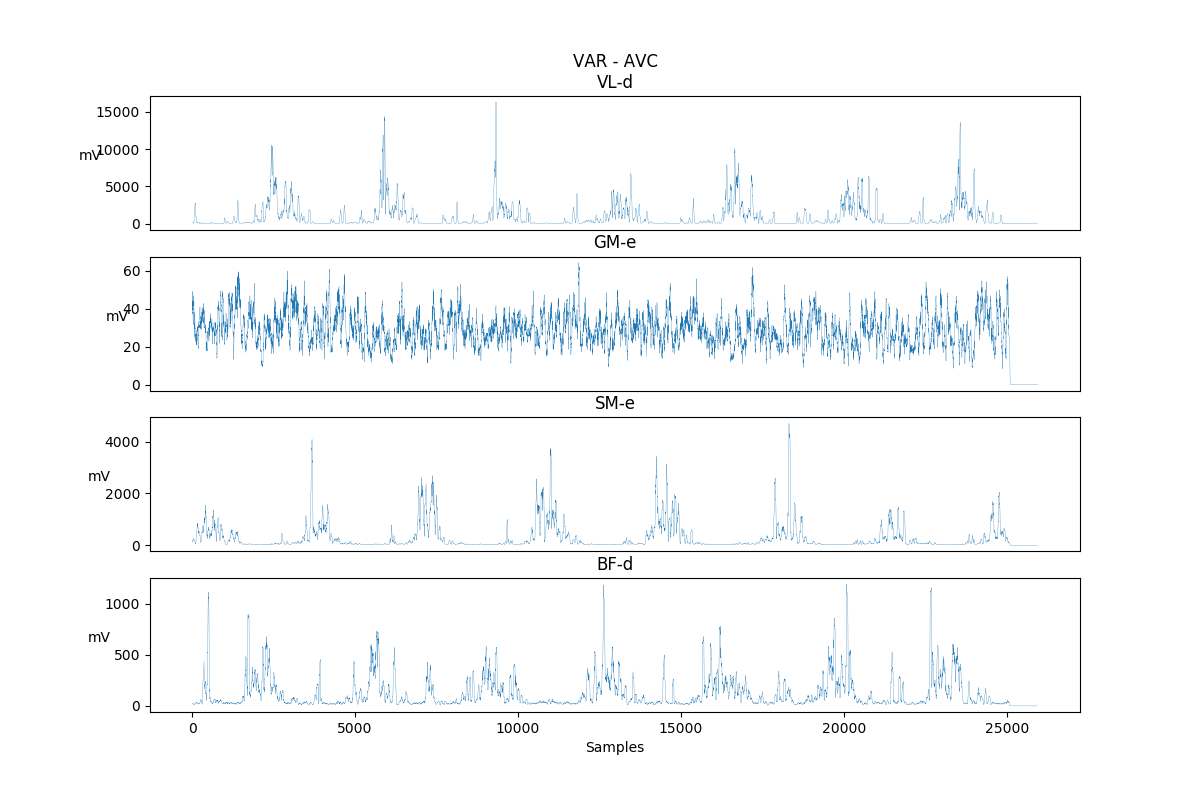

In [265]:
plot_emg("VAR - AVC",var3)

# Feature Extraction

In [5]:
def plot_(FILE_,Xc):    
    
    fig = plt.figure()
    ax1 = plt.subplot(4, 1, 1).xaxis.set_visible(False)
    plt.plot(Xc[:, 0], linewidth=0.2)
    plt.xlabel('Samples')
    plt.ylabel('mV').set_rotation(0)
    plt.title('Channel 1')

    # pass sharey=ax1 to ensure the two subplots share the same y axis
    ax2 = plt.subplot(4, 1, 2, sharey=ax1).xaxis.set_visible(False)
    plt.plot(Xc[:, 1], linewidth=0.2)
    plt.xlabel('Samples')
    plt.ylabel('mV').set_rotation(0)
    plt.title('Channel 2')

    ax3 = plt.subplot(4, 1, 3, sharey=ax1).xaxis.set_visible(False)
    plt.plot(Xc[:, 2], linewidth=0.2)
    plt.xlabel('Samples')
    plt.ylabel('mV').set_rotation(0)
    plt.title('Channel 3')
    
    ax4 = plt.subplot(4, 1, 4, sharey=ax1)
    plt.plot(Xc[:, 3], linewidth=0.2)
    plt.xlabel('Samples')
    plt.ylabel('mV').set_rotation(0)
    plt.title('Channel 4')
    
    #fig_name = FILE_+'_filtered'+str(180)+'.png'
    fig.set_size_inches(w=10,h=7)
    #fig.savefig('./graphs/'+fig_name)

In [28]:
def rms(a, window_size):
    def subrms(a, window_size):
        a2 = np.power(a,2)
        window = np.ones(window_size)/float(window_size)
        return np.sqrt(np.convolve(a2, window, 'valid'))

    for i in range(a.shape[1]):
        if i == 0:
            Xc = subrms(a[:, i], window_size)
        else:
            Xcp = subrms(a[:, i], window_size)
            Xc = np.vstack((Xc,Xcp))
    return np.transpose(Xc)

<IPython.core.display.Javascript object>


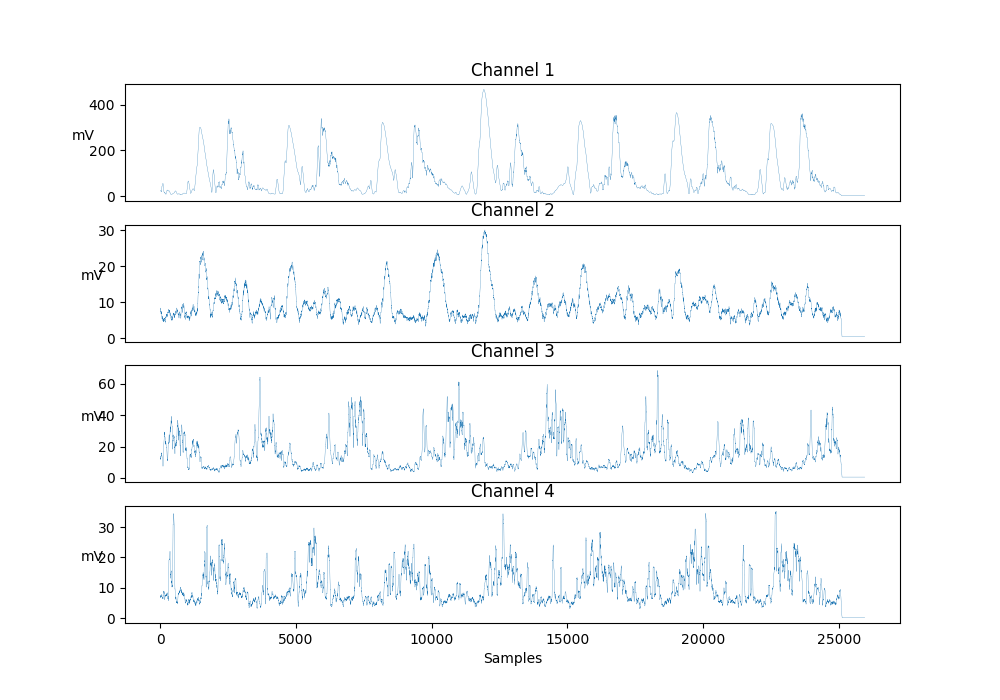


X shape  (26000, 5)


In [42]:

plot_('Alexandre Moreira  - Dia 17.08.25 as 17.25.26',rms(X[:,1:],50))
print '\nX shape ', X.shape

array([[-17.53851541,   6.24074074, -16.33333333, -11.47265625],
       [-11.91554622,   6.24074074,  -3.64761905,  -2.98359375],
       [-10.50980392,  -0.90740741, -16.33333333,  -5.81328125],
       ..., 
       [ -0.66960784,   0.52222222,   0.58095238,  -0.15390625],
       [ -0.66960784,   0.52222222,   0.58095238,  -0.15390625],
       [ -0.66960784,   0.52222222,   0.58095238,  -0.15390625]])